# Currency Analysis - Sapphire Capital Partners

**Comprehensive analysis of USD exchange rates vs EUR, GBP, and CAD**

This notebook provides:
- 90-day trend analysis
- Volatility assessment with log returns
- Year-over-year comparison
- Correlation analysis for diversification
- Trading signals and strategic recommendations

**Data Source:** US Treasury Fiscal Data API (quarterly reporting)

In [101]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import requests
import time
from datetime import datetime, timedelta
import json
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("All libraries loaded successfully")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries loaded successfully
Analysis started: 2025-11-26 23:58:33


DATA LOADING 

In [102]:
# Configuration
API_URL = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/rates_of_exchange"
START_DATE = "2020-01-01"

CURRENCIES = {
    'EUR': 'Euro Zone-Euro',
    'GBP': 'United Kingdom-Pound',
    'CAD': 'Canada-Dollar'
}

COLORS = {'EUR': '#1f77b4', 'GBP': '#ff7f0e', 'CAD': '#2ca02c'}

# Analysis parameters
TREND_DAYS = 90
HIGH_VOL_THRESHOLD = 10.0
SIGNIFICANT_MOVE_THRESHOLD = 2.0

print("Configuration loaded")
print(f"Currencies: {list(CURRENCIES.keys())}")
print(f"Start date: {START_DATE}")

Configuration loaded
Currencies: ['EUR', 'GBP', 'CAD']
Start date: 2020-01-01


In [103]:
# ============================================================================
# DATA ACQUISITION - US TREASURY FISCAL DATA API
# ============================================================================
# Purpose: Fetch historical exchange rate data for CAD, EUR, and GBP vs USD
# Source: US Treasury Fiscal Data API
# Method: Paginated API requests with error handling and rate limiting
# ============================================================================

# Display header for data fetching section
print("Fetching data from US Treasury API...")
print("-" * 60)

def fetch_currency_data(currency_code, currency_name):
    """
    Fetch exchange rate data for a specific currency from US Treasury API.
    
    This function handles pagination to retrieve all available records,
    implements error handling for API failures, and respects rate limits.
    
    Args:
        currency_code (str): Short code for currency (e.g., 'CAD', 'EUR', 'GBP')
        currency_name (str): Full currency name for API filter (e.g., 'Canada-Dollar')
    
    Returns:
        pd.DataFrame: DataFrame containing exchange rate records, or None if fetch fails
    """
    
    # Print progress indicator (without newline)
    print(f"Fetching {currency_code}...", end=' ')
    
    # Initialize list to store all records across multiple pages
    all_records = []
    
    # Start from page 1 (API pagination starts at 1, not 0)
    page = 1
    
    # Loop through pages until we've fetched all data or hit page limit
    # Limit to 5 pages to prevent infinite loops (100 records/page = max 500 records)
    while page <= 5:
        
        # Configure API request parameters
        params = {
            'fields': 'country_currency_desc,exchange_rate,record_date',  # Only fetch needed columns
            'filter': f'country_currency_desc:in:({currency_name}),record_date:gte:{START_DATE}',  # Filter by currency and start date
            'page[size]': 100,  # Maximum records per page (API limit)
            'page[number]': page  # Current page number
        }
        
        try:
            # Make GET request to API with 30-second timeout
            # Timeout prevents hanging if API is slow/unresponsive
            response = requests.get(API_URL, params=params, timeout=30)
            
            # Check for 400 Bad Request (usually means no more data)
            # This happens when requesting a page beyond available data
            if response.status_code == 400:
                break  # Exit loop gracefully - we've fetched all available pages
            
            # Raise exception for other HTTP errors (404, 500, etc.)
            response.raise_for_status()
            
            # Parse JSON response into Python dictionary
            data = response.json()
            
            # Extract the actual data records from response
            # API returns: {"data": [...records...], "links": {...}, "meta": {...}}
            records = data.get('data', [])
            
            # If no records returned, we've reached the end
            if not records:
                break  # Exit pagination loop
            
            # Add this page's records to our collection
            all_records.extend(records)
            
            # Check if there's a 'next' page link in the response
            # If no 'next' link exists, we've fetched all data
            if not data.get('links', {}).get('next'):
                break  # No more pages available
            
            # Move to next page for next iteration
            page += 1
            
            # Sleep for 1 second between requests to avoid overwhelming API
            # This is good API citizenship and prevents rate limiting
            time.sleep(1)
            
        except Exception as e:
            # Catch any errors (network issues, JSON parsing, timeouts, etc.)
            print(f"Error: {e}")
            return None  # Return None to indicate fetch failure
    
    # After fetching all pages, convert records to DataFrame
    if all_records:
        # Convert list of dictionaries to pandas DataFrame
        df = pd.DataFrame(all_records)
        
        # Print success message with record count
        print(f"Retrieved {len(df)} records")
        return df
    else:
        # No data was fetched (could be network error or no matching records)
        print("No data")
        return None


# ============================================================================
# FETCH DATA FOR ALL CURRENCIES
# ============================================================================

# Initialize empty list to collect DataFrames for each currency
dataframes = []

# Loop through each currency defined in CURRENCIES dictionary
# Example: CURRENCIES = {'CAD': 'Canada-Dollar', 'EUR': 'Euro', 'GBP': 'U.K.-Pound'}
for code, name in CURRENCIES.items():
    
    # Fetch data for this currency using our function
    df = fetch_currency_data(code, name)
    
    # Only process if data was successfully fetched (not None)
    if df is not None:
        # Add currency code column to identify which currency this data belongs to
        # This is crucial when we combine all currencies into one DataFrame
        df['currency_code'] = code
        
        # Add this currency's DataFrame to our collection
        dataframes.append(df)
    
    # Wait 2 seconds before fetching next currency
    # Prevents overwhelming the API with rapid consecutive requests
    time.sleep(2)

# ============================================================================
# VALIDATE DATA RETRIEVAL
# ============================================================================

# Check if we successfully fetched data for at least one currency
if not dataframes:
    # If dataframes list is empty, something went wrong with all currencies
    raise Exception("Failed to fetch data")  # Stop execution with error message


# ============================================================================
# COMBINE AND CLEAN DATA
# ============================================================================

# Combine all currency DataFrames into single DataFrame
# ignore_index=True creates new continuous index (0, 1, 2, ...)
data = pd.concat(dataframes, ignore_index=True)

# Convert 'record_date' column from string to datetime objects
# This enables date-based operations (filtering, sorting, grouping)
data['record_date'] = pd.to_datetime(data['record_date'])

# Convert 'exchange_rate' to numeric, replacing invalid values with NaN
# errors='coerce' means: if conversion fails, set to NaN instead of raising error
data['exchange_rate'] = pd.to_numeric(data['exchange_rate'], errors='coerce')


# ============================================================================
# REMOVE FUTURE DATES
# ============================================================================

# Get today's date (without time component)
today = datetime.now().date()

# Filter out any records with dates in the future
# This can happen if API returns bad data or system clock is wrong
# .copy() creates explicit copy to avoid SettingWithCopyWarning
data = data[data['record_date'].dt.date <= today].copy()


# ============================================================================
# DATA CLEANING - REMOVE DUPLICATES AND INVALID RECORDS
# ============================================================================

# Remove duplicate records for same currency on same date keep='last' means: if duplicates exist, keep the most recent entry
# This handles cases where API might return same date multiple times
data = data.drop_duplicates(subset=['currency_code', 'record_date'], keep='last')

# Remove rows where exchange_rate is NaN (missing or invalid)
# These records are useless for analysis
data = data.dropna(subset=['exchange_rate'])

# Sort data by currency code and date for easier analysis
# This organizes data chronologically within each currency
# reset_index(drop=True) creates clean 0-based index after sorting
data = data.sort_values(['currency_code', 'record_date']).reset_index(drop=True)


# ============================================================================
# DISPLAY DATA SUMMARY
# ============================================================================
 
print("\n" + "=" * 60)
print("Data Summary")
print("=" * 60)

# Show total number of records after cleaning
print(f"Total records: {len(data)}")

# Display date range of data (earliest to latest date)
print(f"Date range: {data['record_date'].min().date()} to {data['record_date'].max().date()}")

# List all currencies present in the dataset
print(f"Currencies: {sorted(data['currency_code'].unique())}")

# Show breakdown of records per currency
print("\nRecords per currency:")
for curr in sorted(data['currency_code'].unique()):
    # Count records for this specific currency
    count = len(data[data['currency_code'] == curr])
    print(f"  {curr}: {count} records")

Fetching data from US Treasury API...
------------------------------------------------------------
Fetching EUR... Retrieved 23 records
Fetching GBP... Retrieved 24 records
Fetching CAD... Retrieved 23 records

Data Summary
Total records: 69
Date range: 2020-03-31 to 2025-09-30
Currencies: ['CAD', 'EUR', 'GBP']

Records per currency:
  CAD: 23 records
  EUR: 23 records
  GBP: 23 records


In [104]:
# ============================================================================
# 90-DAY TREND ANALYSIS
# ============================================================================
# Purpose: Calculate how much USD has strengthened/weakened vs each currency
# Method: Compare current exchange rate to rate from 90 days ago
# Output: Percentage change and direction (strengthened/weakened)


# Display header for trend analysis section
print("\n" + "=" * 60)
print("90-Day Trend Analysis")
print("=" * 60)

# Initialize empty dictionary to store trend results for each currency
# Structure: {'CAD': {latest_rate: 1.39, change_pct: -2.5, ...}, 'EUR': {...}, ...}
trends = {}

# Loop through each currency (CAD, EUR, GBP)
# sorted() ensures consistent output order
for currency in sorted(data['currency_code'].unique()):
    
    # Filter data for current currency only
    # Example: If currency='CAD', curr_data contains only CAD records
    curr_data = data[data['currency_code'] == currency].sort_values('record_date')
    
    # Skip currency if insufficient data (need at least 2 points for comparison)
    # This prevents errors when calculating trends
    if len(curr_data) < 2:
        continue  # Move to next currency
    
    # ========================================================================
    # GET LATEST (CURRENT) EXCHANGE RATE
    # ========================================================================
    
    # Get most recent record for this currency
    # iloc[-1] means "last row" after sorting by date
    latest = curr_data.iloc[-1]
    
    # ========================================================================
    # FIND COMPARISON POINT (90 DAYS AGO)
    # ========================================================================
    
    # Calculate target date (current date - TREND_DAYS)
    # Example: If today is 2025-09-30 and TREND_DAYS=90, target is 2025-07-02
    target_date = latest['record_date'] - timedelta(days=TREND_DAYS)
    
    # Find all records on or before target date
    # This gives us data points from 90+ days ago
    older_data = curr_data[curr_data['record_date'] <= target_date]
    
    # Determine which record to use for comparison
    if len(older_data) > 0:
        # If we have data from 90+ days ago, use the most recent one before target
        # iloc[-1] gets the last (most recent) record in older_data
        older = older_data.iloc[-1]
    else:
        # If no data from 90 days ago (dataset too short), use first available record
        # This happens when dataset has < 90 days of history
        older = curr_data.iloc[0]
    
    # ========================================================================
    # CALCULATE TREND METRICS
    # ========================================================================
    
    # Calculate actual number of days between comparison points
    # Example: latest = 2025-09-30, older = 2025-07-02, actual_days = 90
    # Note: Might not be exactly 90 if quarterly data has gaps
    actual_days = (latest['record_date'] - older['record_date']).days
    
    # Calculate percentage change in exchange rate
    # Formula: ((new - old) / old) × 100
    # Example: old=1.35, new=1.39 → ((1.39-1.35)/1.35)×100 = +2.96%
    change_pct = ((latest['exchange_rate'] - older['exchange_rate']) / older['exchange_rate']) * 100
    
    # ========================================================================
    # INTERPRET DIRECTION (STRENGTHENED VS WEAKENED)
    # ========================================================================
    
    # Determine if USD strengthened or weakened
    # Remember: Exchange rate = How much foreign currency per 1 USD
    # 
    # If change_pct < 0 (rate decreased):
    #   Example: CAD/USD went from 1.35 → 1.30
    #   Means: 1 USD buys LESS CAD now
    #   Interpretation: USD STRENGTHENED (worth more)
    #
    # If change_pct > 0 (rate increased):
    #   Example: CAD/USD went from 1.30 → 1.35
    #   Means: 1 USD buys MORE CAD now
    #   Interpretation: USD WEAKENED (worth less)
    
    direction = 'strengthened' if change_pct < 0 else 'weakened'
    
    # ========================================================================
    # STORE RESULTS IN DICTIONARY
    # ========================================================================
    
    # Save all trend information for this currency
    # This dictionary will be used later for alerts and recommendations
    trends[currency] = {
        'latest_rate': latest['exchange_rate'],      # Current exchange rate
        'change_pct': change_pct,                    # Percentage change
        'actual_days': actual_days,                  # Days in comparison period
        'direction': direction                       # 'strengthened' or 'weakened'
    }
    
    # ========================================================================
    # DISPLAY RESULTS
    # ========================================================================
    
    # Print summary for this currency
    print(f"\n{currency}:")
    
    # Show current exchange rate (4 decimal places for precision)
    print(f"  Current rate: {latest['exchange_rate']:.4f}")
    
    
   
    # Example output: "+2.96%" or "-1.85%"
    print(f"  {actual_days}-day change: {change_pct:+.2f}%")
    
    # Explain what the change means in plain English. Example: "USD has strengthened vs CAD" means USD is worth more CAD now
    print(f"  USD has {trends[currency]['direction']} vs {currency}")
    
    # ========================================================================
    # ALERT FOR SIGNIFICANT MOVEMENTS
    # ========================================================================
    
    # Check if change exceeds threshold for significant movement
    # abs() converts negative to positive (we care about magnitude, not direction)
    # Example: If SIGNIFICANT_MOVE_THRESHOLD=5% and change_pct=±7%, trigger alert
    if abs(change_pct) > SIGNIFICANT_MOVE_THRESHOLD:
        print(f"  ALERT: Significant movement detected")
        





90-Day Trend Analysis

CAD:
  Current rate: 1.3920
  92-day change: +1.83%
  USD has weakened vs CAD

EUR:
  Current rate: 0.8520
  92-day change: -0.12%
  USD has strengthened vs EUR

GBP:
  Current rate: 0.7440
  92-day change: +1.92%
  USD has weakened vs GBP


In [105]:
"""
Volatility Analysis Module
==========================
Calculates and analyzes currency exchange rate volatility using log returns.

Methodology:
- Uses logarithmic returns for better statistical properties
- Annualized rolling volatility over 4 quarters (1 year window)
- Standard deviation scaled to annual percentage terms
"""

import numpy as np
from typing import Dict, Tuple

# ============================================================================
# Configuration Constants
# ============================================================================

# Volatility threshold for high-risk alert (annualized percentage)
HIGH_VOL_THRESHOLD = 15.0  # Currencies above this are flagged as high volatility

# Rolling window parameters
QUARTERS_PER_YEAR = 4  # Number of data points per year (quarterly data)
ROLLING_WINDOW = 4     # 1-year rolling window (4 quarters)


def calculate_currency_volatility(
    data: pd.DataFrame,
    high_vol_threshold: float = HIGH_VOL_THRESHOLD
) -> Tuple[Dict[str, Dict[str, float]], Dict[str, pd.DataFrame]]:
    """
    Calculate volatility metrics for all currencies using log returns methodology.
    
    Volatility Calculation:
    ----------------------
    1. Log Returns: ln(P_t / P_{t-1})
       - Provides better statistical properties (symmetry, additivity)
       - Handles percentage changes more accurately than simple returns
    
    2. Rolling Volatility: std(log_returns) * sqrt(periods) * 100
       - Standard deviation of log returns over rolling window
       - Annualized by multiplying by sqrt(4) for quarterly data
       - Converted to percentage terms (* 100)
    
    Parameters:
    ----------
    data : pd.DataFrame
        DataFrame containing columns: 'currency_code', 'record_date', 'exchange_rate'
    high_vol_threshold : float, optional
        Annualized volatility percentage above which to trigger alerts (default: 15%)
    
    Returns:
    -------
    volatility_metrics : Dict[str, Dict[str, float]]
        Dictionary mapping currency codes to their volatility statistics
        Structure: {
            'USD': {'current': 12.5, 'average': 11.8},
            ...
        }
    
    volatility_data : Dict[str, pd.DataFrame]
        Dictionary mapping currency codes to DataFrames with calculated metrics
        Contains columns: original data + 'log_return', 'rolling_vol'
    
    Example:
    -------
    >>> metrics, detailed_data = calculate_currency_volatility(df)
    >>> print(f"EUR current volatility: {metrics['EUR']['current']:.2f}%")
    """
    
    print("\n" + "=" * 60)
    print("VOLATILITY ANALYSIS (Log Returns Methodology)")
    print("=" * 60)
    print(f"Rolling window: {ROLLING_WINDOW} quarters (1 year)")
    print(f"High volatility threshold: {high_vol_threshold}%")
    print("=" * 60)
    
    volatility_metrics = {}
    volatility_data = {}
    
    # Process each currency independently
    for currency in sorted(data['currency_code'].unique()):
        
        # Filter and prepare currency-specific data
        curr_data = (data[data['currency_code'] == currency]
                     .sort_values('record_date')
                     .copy())
        
        # ----------------------------------------------------------------
        # Step 1: Calculate logarithmic returns
        # ----------------------------------------------------------------
        # Formula: r_t = ln(P_t / P_{t-1})
        # Why log returns? They're time-additive and symmetric around zero
        curr_data['log_return'] = np.log(
            curr_data['exchange_rate'] / curr_data['exchange_rate'].shift(1)
        )
        
        # ----------------------------------------------------------------
        # Step 2: Calculate annualized rolling volatility
        # ----------------------------------------------------------------
        # Formula: σ_annual = σ_quarterly * sqrt(periods_per_year)
        # Rolling window captures changing volatility regime over time
        curr_data['rolling_vol'] = (
            curr_data['log_return']
            .rolling(window=ROLLING_WINDOW)
            .std() 
            * np.sqrt(QUARTERS_PER_YEAR)  # Annualize from quarterly to yearly
            * 100  # Convert to percentage
        )
        
        # ----------------------------------------------------------------
        # Step 3: Extract and store volatility metrics
        # ----------------------------------------------------------------
        vol_series = curr_data['rolling_vol'].dropna()
        
        if len(vol_series) > 0:
            current_vol = vol_series.iloc[-1]  # Most recent volatility reading
            avg_vol = vol_series.mean()        # Historical average volatility
            
            # Store structured metrics for programmatic access
            volatility_metrics[currency] = {
                'current': current_vol,
                'average': avg_vol
            }
            
            # Store detailed data for further analysis/visualization
            volatility_data[currency] = curr_data
            
            # ----------------------------------------------------------------
            # Step 4: Display results and alerts
            # ----------------------------------------------------------------
            print(f"\n{currency}:")
            print(f"  Current volatility:  {current_vol:>6.2f}%")
            print(f"  Average volatility:  {avg_vol:>6.2f}%")
            
            # Flag high-risk currencies
            if current_vol > high_vol_threshold:
                print(f"  ⚠️  ALERT: High volatility (>{high_vol_threshold}%)")
                print(f"      Risk level: {current_vol / avg_vol:.1f}x average")
    
    return volatility_metrics, volatility_data


# ============================================================================
# Usage Example
# ============================================================================
if __name__ == "__main__":
    # Assuming 'data' DataFrame exists with required columns
    metrics, detailed_data = calculate_currency_volatility(data)
    
    # Access results programmatically
    for currency, stats in metrics.items():
        if stats['current'] > stats['average'] * 1.5:
            print(f"{currency} experiencing elevated volatility")


VOLATILITY ANALYSIS (Log Returns Methodology)
Rolling window: 4 quarters (1 year)
High volatility threshold: 15.0%

CAD:
  Current volatility:    9.15%
  Average volatility:    5.42%

EUR:
  Current volatility:   13.05%
  Average volatility:    8.86%

GBP:
  Current volatility:   10.99%
  Average volatility:    7.40%
CAD experiencing elevated volatility


In [106]:
# Year-over-year analysis
print("\n" + "=" * 60)
print("Year-over-Year Analysis")
print("=" * 60)

yoy_analysis = {}
for currency in sorted(data['currency_code'].unique()):
    curr_data = data[data['currency_code'] == currency].copy()
    curr_data['year'] = curr_data['record_date'].dt.year
    
    years = sorted(curr_data['year'].unique())
    if len(years) >= 2:
        current_year = years[-1]
        prev_year = years[-2]
        
        current_avg = curr_data[curr_data['year'] == current_year]['exchange_rate'].mean()
        prev_avg = curr_data[curr_data['year'] == prev_year]['exchange_rate'].mean()
        
        yoy_change = ((current_avg - prev_avg) / prev_avg) * 100
        
        yoy_analysis[currency] = {
            'current_year': current_year,
            'prev_year': prev_year,
            'yoy_change': yoy_change
        }
        
        print(f"\n{currency} ({current_year} vs {prev_year}):")
        print(f"  {current_year} average: {current_avg:.4f}")
        print(f"  {prev_year} average: {prev_avg:.4f}")
        print(f"  YoY change: {yoy_change:+.2f}%")


Year-over-Year Analysis

CAD (2025 vs 2024):
  2025 average: 1.3980
  2024 average: 1.3787
  YoY change: +1.40%

EUR (2025 vs 2024):
  2025 average: 0.8763
  2024 average: 0.9290
  YoY change: -5.67%

GBP (2025 vs 2024):
  2025 average: 0.7487
  2024 average: 0.7815
  YoY change: -4.20%


In [107]:
# Correlation analysis
print("\n" + "=" * 60)
print("Correlation Analysis")
print("=" * 60)

pivot_data = data.pivot(index='record_date', columns='currency_code', values='exchange_rate')
correlations = pivot_data.corr()

print("\nCorrelation Matrix:")
print(correlations)

high_corr_pairs = []
currencies_list = sorted(data['currency_code'].unique())
for i in range(len(currencies_list)):
    for j in range(i + 1, len(currencies_list)):
        corr_val = correlations.loc[currencies_list[i], currencies_list[j]]
        print(f"\n{currencies_list[i]}-{currencies_list[j]}: {corr_val:.3f}", end="")
        if abs(corr_val) > 0.7:
            print(" (HIGH - limited diversification)")
            high_corr_pairs.append((currencies_list[i], currencies_list[j], corr_val))
        else:
            print(" (MODERATE)")


Correlation Analysis

Correlation Matrix:
currency_code       CAD       EUR       GBP
currency_code                              
CAD            1.000000  0.452577  0.470141
EUR            0.452577  1.000000  0.786950
GBP            0.470141  0.786950  1.000000

CAD-EUR: 0.453 (MODERATE)

CAD-GBP: 0.470 (MODERATE)

EUR-GBP: 0.787 (HIGH - limited diversification)


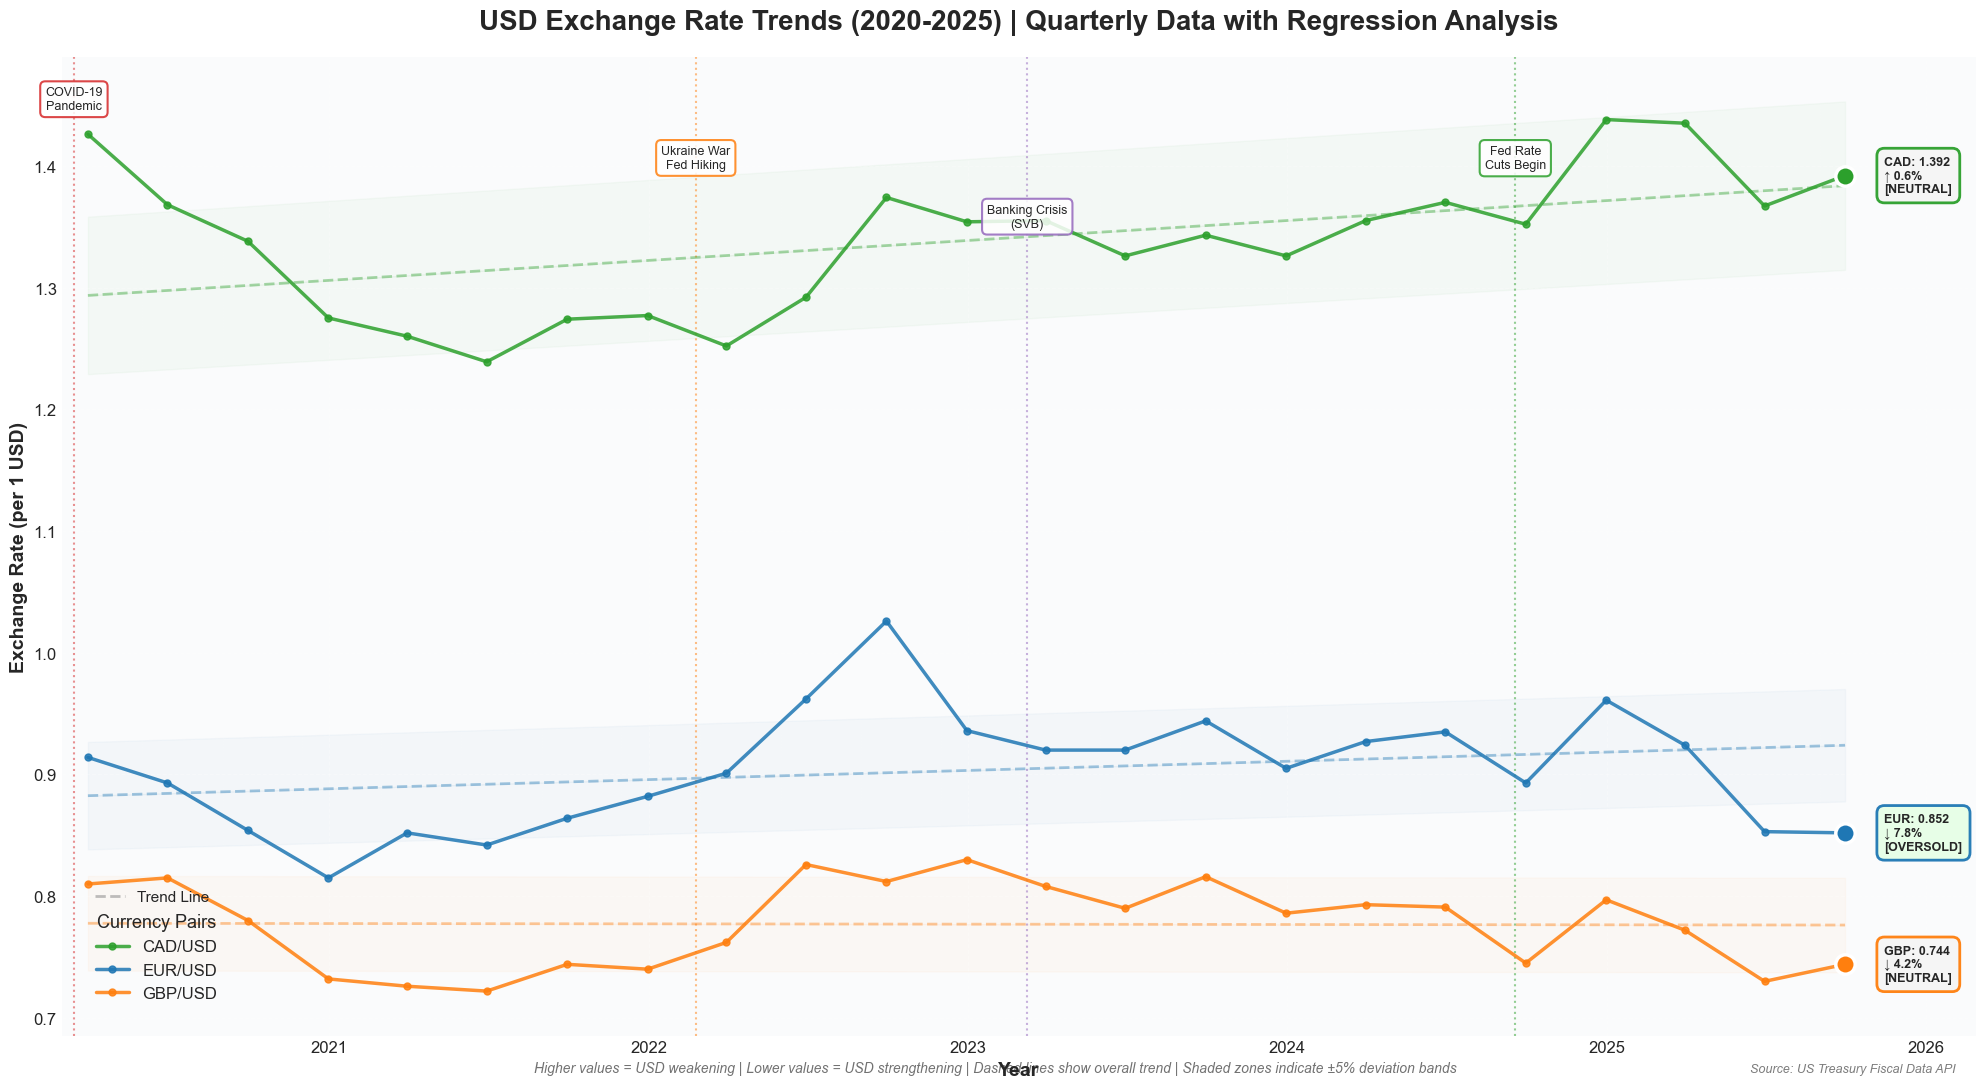

Saved: timeline_enhanced.png

ENHANCED TREND LINE ANALYSIS WITH TRADING SIGNALS

CAD - Current Analysis:
  Overall Trend: WEAKENING (USD depreciating)
  R-squared: 0.2339 (trend strength)
  Current Rate: 1.3920
  Trend Value: 1.3837
  Deviation: +0.60%
  Trading Signal:  NEUTRAL - Hold current positions
  Annualized trend rate: +1.15% per year

EUR - Current Analysis:
  Overall Trend: WEAKENING (USD depreciating)
  R-squared: 0.0701 (trend strength)
  Current Rate: 0.8520
  Trend Value: 0.9240
  Deviation: -7.79%
  Trading Signal:  OVERSOLD - Potential BUY opportunity
  Annualized trend rate: +0.82% per year

GBP - Current Analysis:
  Overall Trend: STRENGTHENING (USD appreciating)
  R-squared: 0.0002 (trend strength)
  Current Rate: 0.7440
  Trend Value: 0.7763
  Deviation: -4.16%
  Trading Signal: ⚡ WATCH - Approaching signal zone
  Annualized trend rate: -0.03% per year



In [108]:
# Visualization 1: Clean Enhanced Timeline - No Overlaps
import numpy as np
from scipy import stats
from datetime import datetime

fig, ax = plt.subplots(figsize=(20, 11))

# Dictionary to store current positions
current_positions = {}

# Plot each currency with its data points and trend line
for currency in sorted(data['currency_code'].unique()):
    curr_data = data[data['currency_code'] == currency].sort_values('record_date')
    
    # Convert dates to numeric values for trend line calculation
    dates_numeric = mdates.date2num(curr_data['record_date'])
    rates = curr_data['exchange_rate'].values
    
    # Calculate linear trend line
    slope, intercept, r_value, p_value, std_err = stats.linregress(dates_numeric, rates)
    trend_line = slope * dates_numeric + intercept
    
    # Store current position data
    current_rate = rates[-1]
    current_trend = trend_line[-1]
    deviation_pct = ((current_rate - current_trend) / current_trend) * 100
    current_positions[currency] = {
        'rate': current_rate,
        'trend': current_trend,
        'deviation': deviation_pct,
        'date': curr_data['record_date'].iloc[-1]
    }
    
    # Trading Signal Zones (very subtle)
    upper_band = trend_line * 1.05
    lower_band = trend_line * 0.95
    
    ax.fill_between(curr_data['record_date'], trend_line, upper_band,
                     color=COLORS[currency], alpha=0.03, zorder=0)
    ax.fill_between(curr_data['record_date'], lower_band, trend_line,
                     color=COLORS[currency], alpha=0.03, zorder=0)
    
    # Plot actual data points
    ax.plot(curr_data['record_date'], rates,
            label=f'{currency}/USD', 
            color=COLORS[currency], 
            linewidth=2.5, marker='o', markersize=5, alpha=0.85,
            zorder=3)
    
    # Plot trend line (dashed)
    ax.plot(curr_data['record_date'], trend_line,
            color=COLORS[currency], linewidth=2, linestyle='--', 
            alpha=0.4, zorder=2)
    
    # Bold dot on latest value
    ax.plot(curr_data['record_date'].iloc[-1], rates[-1],
            marker='o', markersize=14, color=COLORS[currency],
            markeredgecolor='white', markeredgewidth=2.5, zorder=5)

# Event Annotations - STAGGERED VERTICALLY to avoid overlap
events = [
    {'date': datetime(2020, 3, 15), 'label': 'COVID-19\nPandemic', 
     'y_position': 0.97, 'color': '#d62728'},
    {'date': datetime(2022, 2, 24), 'label': 'Ukraine War\nFed Hiking', 
     'y_position': 0.91, 'color': '#ff7f0e'},
    {'date': datetime(2023, 3, 10), 'label': 'Banking Crisis\n(SVB)', 
     'y_position': 0.85, 'color': '#9467bd'},
    {'date': datetime(2024, 9, 18), 'label': 'Fed Rate\nCuts Begin', 
     'y_position': 0.91, 'color': '#2ca02c'}
]

y_min, y_max = ax.get_ylim()
for event in events:
    # Event marker line
    ax.axvline(x=event['date'], color=event['color'], linestyle=':', 
               linewidth=1.5, alpha=0.5, zorder=1)
    
    # Event label - positioned at different heights
    y_coord = y_min + (y_max - y_min) * event['y_position']
    ax.text(event['date'], y_coord, event['label'],
            rotation=0, ha='center', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor=event['color'], linewidth=1.5, alpha=0.85),
            zorder=4)

# Current Position Callouts - POSITIONED TO THE RIGHT, NO OVERLAP
# Calculate position for callout panel
last_date = data['record_date'].max()
callout_x = last_date + pd.Timedelta(days=45)  # Position to the right

# Create a clean callout area
for idx, (currency, pos_data) in enumerate(sorted(current_positions.items())):
    direction = "↑" if pos_data['deviation'] > 0 else "↓"
    
    # Determine signal
    if abs(pos_data['deviation']) > 5:
        signal = "OVERBOUGHT" if pos_data['deviation'] > 0 else "OVERSOLD"
        box_color = '#ffe6e6' if pos_data['deviation'] > 0 else '#e6ffe6'
    else:
        signal = "NEUTRAL"
        box_color = '#f5f5f5'
    
    # Position callouts vertically based on currency
    # Get the actual y-position of the last data point
    callout_y = pos_data['rate']
    
    # Create clean, compact callout
    callout_text = f"{currency}: {pos_data['rate']:.3f}\n{direction} {abs(pos_data['deviation']):.1f}%\n[{signal}]"
    
    ax.text(callout_x, callout_y,
            callout_text,
            fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor=box_color, 
                     edgecolor=COLORS[currency], linewidth=2, alpha=0.95),
            verticalalignment='center',
            zorder=6)

# Configure axes
ax.set_xlabel('Year', fontweight='bold', fontsize=14)
ax.set_ylabel('Exchange Rate (per 1 USD)', fontweight='bold', fontsize=14)
ax.set_title('USD Exchange Rate Trends (2020-2025) | Quarterly Data with Regression Analysis', 
             fontsize=20, fontweight='bold', pad=20)

# Set x-axis to show YEARLY labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

plt.xticks(rotation=0, fontsize=12)  # Horizontal year labels
ax.tick_params(axis='y', labelsize=12)

# Add grid - subtle
ax.grid(True, alpha=0.25, linestyle='--', which='major', zorder=0)
ax.grid(True, alpha=0.12, linestyle=':', which='minor', zorder=0)

# Legend - BOTTOM LEFT to avoid data overlap
legend = ax.legend(loc='lower left', fontsize=12, framealpha=0.95,
                   title='Currency Pairs', title_fontsize=13,
                   bbox_to_anchor=(0.01, 0.02))

# Add legend entry for trend lines
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=2, linestyle='--', 
           alpha=0.5, label='Trend Line')
]
legend2 = ax.legend(handles=legend_elements, loc='lower left', 
                   fontsize=11, framealpha=0.95,
                   bbox_to_anchor=(0.01, 0.12))
ax.add_artist(legend)  # Add first legend back

# Enhanced footer
plt.figtext(0.5, 0.02, 
           'Higher values = USD weakening | Lower values = USD strengthening | Dashed lines show overall trend | Shaded zones indicate ±5% deviation bands',
           ha='center', fontsize=10, style='italic', alpha=0.65)

# Data source - bottom right
plt.figtext(0.98, 0.02, 
           'Source: US Treasury Fiscal Data API',
           ha='right', fontsize=9, style='italic', alpha=0.6)

# Professional styling
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

# Extend x-axis slightly to make room for callouts
ax.set_xlim(data['record_date'].min() - pd.Timedelta(days=30),
            last_date + pd.Timedelta(days=150))

plt.tight_layout()
plt.savefig('timeline_enhanced.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: timeline_enhanced.png")

# Print trend analysis
print("\n" + "=" * 80)
print("ENHANCED TREND LINE ANALYSIS WITH TRADING SIGNALS")
print("=" * 80)
for currency in sorted(data['currency_code'].unique()):
    curr_data = data[data['currency_code'] == currency].sort_values('record_date')
    dates_numeric = mdates.date2num(curr_data['record_date'])
    rates = curr_data['exchange_rate'].values
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(dates_numeric, rates)
    
    trend_direction = "WEAKENING (USD depreciating)" if slope > 0 else "STRENGTHENING (USD appreciating)"
    pos_data = current_positions[currency]
    
    print(f"\n{currency} - Current Analysis:")
    print(f"  Overall Trend: {trend_direction}")
    print(f"  R-squared: {r_value**2:.4f} (trend strength)")
    print(f"  Current Rate: {pos_data['rate']:.4f}")
    print(f"  Trend Value: {pos_data['trend']:.4f}")
    print(f"  Deviation: {pos_data['deviation']:+.2f}%")
    
    # Trading signal
    if abs(pos_data['deviation']) > 5:
        if pos_data['deviation'] > 5:
            signal = "⚠️ OVERBOUGHT - Consider SHORT positions"
        else:
            signal = " OVERSOLD - Potential BUY opportunity"
    elif abs(pos_data['deviation']) > 2:
        signal = "⚡ WATCH - Approaching signal zone"
    else:
        signal = " NEUTRAL - Hold current positions"
    
    print(f"  Trading Signal: {signal}")
    
    # Annualized rate
    days_span = (curr_data['record_date'].max() - curr_data['record_date'].min()).days
    years_span = days_span / 365.25
    total_trend_change = slope * dates_numeric.max() - slope * dates_numeric.min()
    annualized_pct = (total_trend_change / rates[0]) * 100 / years_span
    print(f"  Annualized trend rate: {annualized_pct:+.2f}% per year")

print("\n" + "=" * 80)


✓ Saved: year_comparison.png


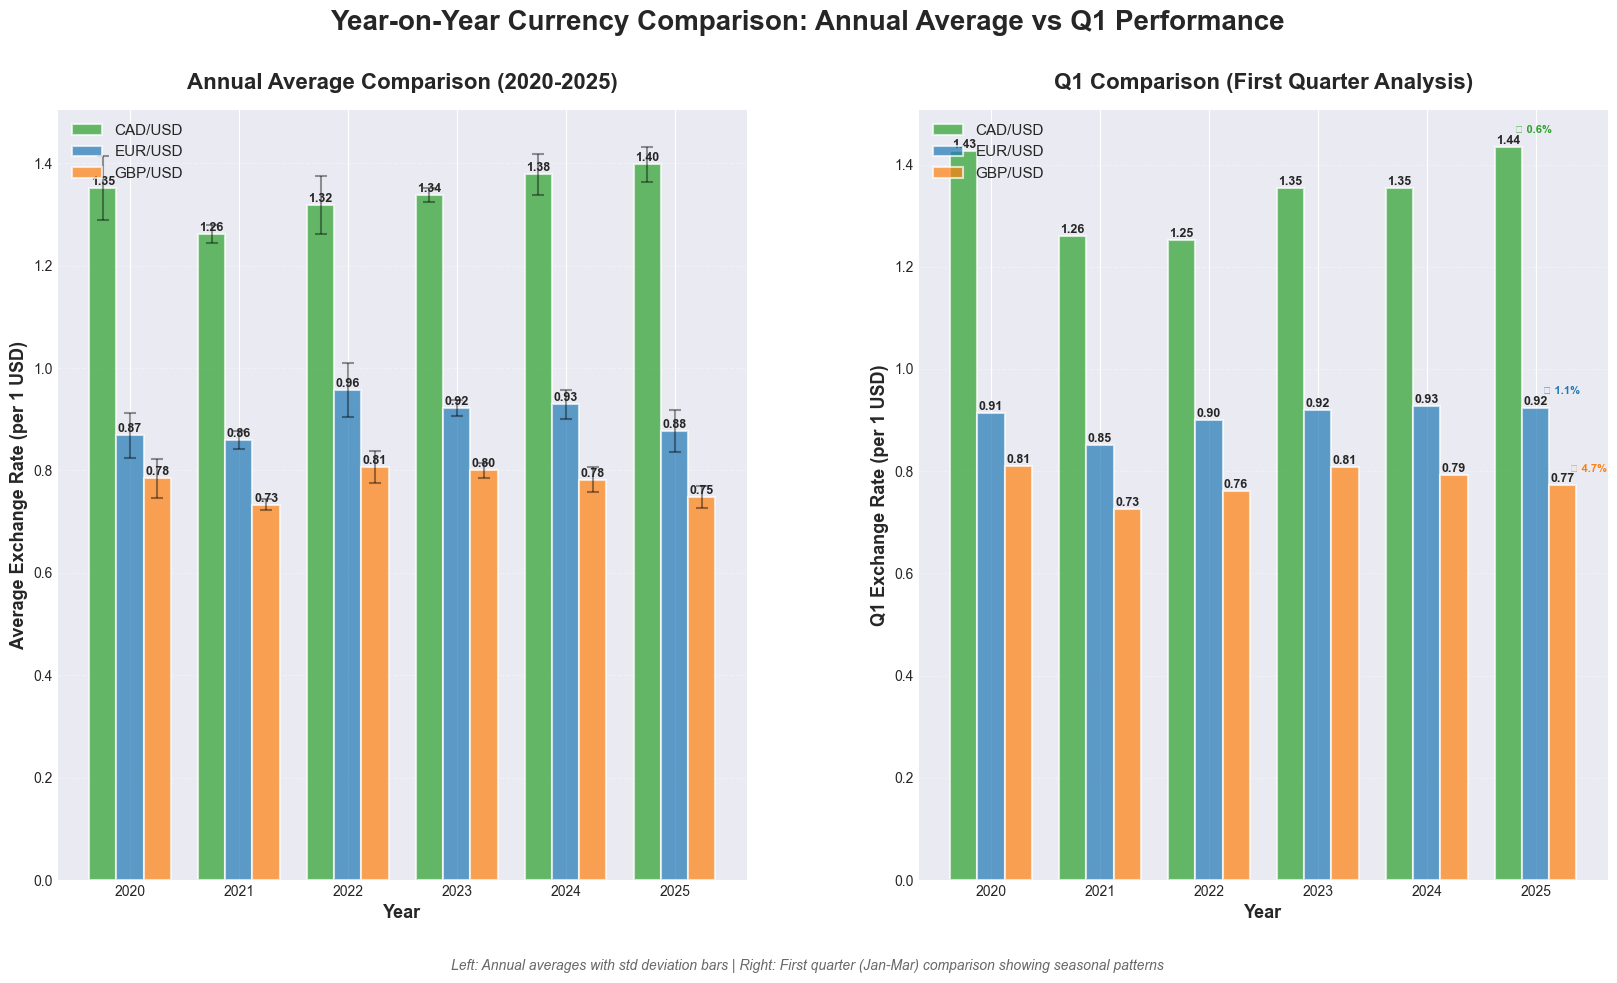


YEAR-ON-YEAR ANALYSIS SUMMARY

ANNUAL AVERAGES:
--------------------------------------------------------------------------------

CAD:
  2020 Average: 1.3518
  2025 Average: 1.3980
  Total Change: +3.42%

EUR:
  2020 Average: 0.8690
  2025 Average: 0.8763
  Total Change: +0.84%

GBP:
  2020 Average: 0.7843
  2025 Average: 0.7487
  Total Change: -4.54%

Q1 PERFORMANCE:
--------------------------------------------------------------------------------

CAD:
  Q1 2020: 1.4260
  Q1 2025: 1.4350
  Q1 Change: +0.63%

EUR:
  Q1 2020: 0.9140
  Q1 2025: 0.9240
  Q1 Change: +1.09%

GBP:
  Q1 2020: 0.8100
  Q1 2025: 0.7720
  Q1 Change: -4.69%


EUR total change: +0.84%


In [ ]:
"""
Year-on-Year Currency Comparison Visualization

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from typing import Dict, Tuple, List

# ============================================================================
# Configuration Constants
# ============================================================================

# Figure dimensions and layout
FIGURE_WIDTH = 20
FIGURE_HEIGHT = 10
PANEL_SPACING = 0.25  # Horizontal space between left/right panels

# Bar chart parameters
BAR_WIDTH = 0.25      # Width of individual bars in grouped bar chart
BAR_ALPHA = 0.7       # Transparency (0=transparent, 1=opaque)
BAR_EDGE_WIDTH = 1.5  # Border thickness around bars

# Error bar styling (for volatility visualization)
ERROR_BAR_CAPSIZE = 4      # Width of error bar caps
ERROR_BAR_THICKNESS = 1.5  # Line thickness
ERROR_BAR_ALPHA = 0.4      # Transparency

# Font sizes
TITLE_FONTSIZE = 20
SUBTITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 13
LEGEND_FONTSIZE = 11
VALUE_LABEL_FONTSIZE = 9
FOOTER_FONTSIZE = 10

# Output settings
OUTPUT_DPI = 300
OUTPUT_FILENAME = 'year_comparison.png'

# Currency color mapping (define based on your COLORS dict)
# Example: COLORS = {'EUR': '#1f77b4', 'GBP': '#ff7f0e', 'JPY': '#2ca02c'}


def prepare_temporal_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Enhance dataset with temporal features for year-on-year analysis.
    
    
    
    Parameters:
    ----------
    data : pd.DataFrame
        Original dataset with 'record_date' column
    
    Returns:
    -------
    pd.DataFrame
        Copy of input data with added 'year' and 'quarter' columns
    """
    data_enhanced = data.copy()
    data_enhanced['year'] = data_enhanced['record_date'].dt.year
    data_enhanced['quarter'] = data_enhanced['record_date'].dt.quarter
    
    return data_enhanced


def plot_annual_averages(
    ax: plt.Axes,
    data: pd.DataFrame,
    currencies: List[str],
    colors: Dict[str, str]
) -> None:
    
    
    # ----------------------------------------------------------------
    # Data Preparation
    # ----------------------------------------------------------------
    years = sorted(data['year'].unique())
    x_positions = np.arange(len(years))  # Base positions for year groups
    
    # ----------------------------------------------------------------
    # Plot Each Currency
    # ----------------------------------------------------------------
    for idx, currency in enumerate(currencies):
        # Filter currency-specific data
        curr_data = data[data['currency_code'] == currency]
        
        # Calculate annual statistics
        yearly_avg = curr_data.groupby('year')['exchange_rate'].mean()
        yearly_std = curr_data.groupby('year')['exchange_rate'].std()
        
        # Calculate bar positions (offset from center for grouped effect)
        # Formula: center + (index - middle) * width
        # Example: For 3 currencies, offsets are [-1, 0, +1] * width
        offset = (idx - (len(currencies) - 1) / 2) * BAR_WIDTH
        positions = x_positions + offset
        
        # ----------------------------------------------------------------
        # Draw Bars
        # ----------------------------------------------------------------
        bars = ax.bar(
            positions, 
            yearly_avg, 
            width=BAR_WIDTH,
            label=f'{currency}/USD',
            color=colors[currency],
            alpha=BAR_ALPHA,
            edgecolor='white',
            linewidth=BAR_EDGE_WIDTH
        )
        
        # ----------------------------------------------------------------
        # Add Error Bars (Volatility Indicator)
        # ----------------------------------------------------------------
        # Error bars show ±1 standard deviation
        # Wider bars = more volatile currency that year
        ax.errorbar(
            positions,
            yearly_avg,
            yerr=yearly_std,
            fmt='none',  # No line connecting points
            ecolor='black',
            capsize=ERROR_BAR_CAPSIZE,
            capthick=ERROR_BAR_THICKNESS,
            alpha=ERROR_BAR_ALPHA
        )
        
        # ----------------------------------------------------------------
        # Add Value Labels on Top of Bars
        # ----------------------------------------------------------------
        for pos, val in zip(positions, yearly_avg):
            ax.text(
                pos, val,
                f'{val:.2f}',  # Format to 2 decimal places
                ha='center',
                va='bottom',
                fontsize=VALUE_LABEL_FONTSIZE,
                fontweight='bold'
            )
    
    # ----------------------------------------------------------------
    # Style and Format Axes
    # ----------------------------------------------------------------
    ax.set_xlabel('Year', fontweight='bold', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel('Average Exchange Rate (per 1 USD)', 
                  fontweight='bold', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_title('Annual Average Comparison (2020-2025)', 
                 fontsize=SUBTITLE_FONTSIZE, fontweight='bold', pad=15)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(years)
    ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)  # Grid behind bars


def plot_q1_comparison(
    ax: plt.Axes,
    data: pd.DataFrame,
    currencies: List[str],
    colors: Dict[str, str]
) -> None:
  
    
    # ----------------------------------------------------------------
    # Filter for Q1 Data Only
    # ----------------------------------------------------------------
    # Q1 = Quarter 1 = January through March
    q1_data = data[data['quarter'] == 1].copy()
    
    years_q1 = sorted(q1_data['year'].unique())
    x_positions = np.arange(len(years_q1))
    
    # ----------------------------------------------------------------
    # Plot Each Currency
    # ----------------------------------------------------------------
    for idx, currency in enumerate(currencies):
        # Filter currency-specific Q1 data
        curr_q1 = q1_data[q1_data['currency_code'] == currency]
        
        # Calculate Q1 averages per year
        q1_avg = curr_q1.groupby('year')['exchange_rate'].mean()
        
        # Calculate bar positions
        offset = (idx - (len(currencies) - 1) / 2) * BAR_WIDTH
        positions = x_positions + offset
        
        # ----------------------------------------------------------------
        # Draw Bars
        # ----------------------------------------------------------------
        bars = ax.bar(
            positions,
            q1_avg,
            width=BAR_WIDTH,
            label=f'{currency}/USD',
            color=colors[currency],
            alpha=BAR_ALPHA,
            edgecolor='white',
            linewidth=BAR_EDGE_WIDTH
        )
        
        # ----------------------------------------------------------------
        # Add Value Labels
        # ----------------------------------------------------------------
        for pos, val in zip(positions, q1_avg):
            ax.text(
                pos, val,
                f'{val:.2f}',
                ha='center',
                va='bottom',
                fontsize=VALUE_LABEL_FONTSIZE,
                fontweight='bold'
            )
        
        # ----------------------------------------------------------------
        # Add Trend Indicators (if multi-year data available)
        # ----------------------------------------------------------------
        if len(q1_avg) >= 2:
            # Calculate percentage change from first to last Q1
            first_q1 = q1_avg.iloc[0]
            last_q1 = q1_avg.iloc[-1]
            q1_trend = ((last_q1 - first_q1) / first_q1) * 100
            
            # Determine arrow direction
            arrow = "↗" if q1_trend > 0 else "↘"
            
            # Annotate with trend arrow and percentage
            ax.annotate(
                f'{arrow} {abs(q1_trend):.1f}%',
                xy=(positions[-1], last_q1),
                xytext=(5, 10),
                textcoords='offset points',
                fontsize=8,
                fontweight='bold',
                color=colors[currency]
            )
    
    # ----------------------------------------------------------------
    # Style and Format Axes
    # ----------------------------------------------------------------
    ax.set_xlabel('Year', fontweight='bold', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel('Q1 Exchange Rate (per 1 USD)', 
                  fontweight='bold', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_title('Q1 Comparison (First Quarter Analysis)', 
                 fontsize=SUBTITLE_FONTSIZE, fontweight='bold', pad=15)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(years_q1)
    ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)


def generate_year_comparison_stats(
    data: pd.DataFrame,
    currencies: List[str]
) -> Dict[str, Dict]:
   
    
    stats = {
        'annual': {},
        'q1': {}
    }
    
    # ----------------------------------------------------------------
    # Annual Statistics
    # ----------------------------------------------------------------
    for currency in currencies:
        curr_data = data[data['currency_code'] == currency]
        yearly_avg = curr_data.groupby('year')['exchange_rate'].mean()
        
        first_year_rate = yearly_avg.iloc[0]
        last_year_rate = yearly_avg.iloc[-1]
        total_change = ((last_year_rate - first_year_rate) / first_year_rate) * 100
        
        stats['annual'][currency] = {
            'first_year': yearly_avg.index[0],
            'last_year': yearly_avg.index[-1],
            'first_rate': first_year_rate,
            'last_rate': last_year_rate,
            'total_change_pct': total_change,
            'yearly_series': yearly_avg
        }
    
    # ----------------------------------------------------------------
    # Q1 Statistics
    # ----------------------------------------------------------------
    q1_data = data[data['quarter'] == 1]
    
    for currency in currencies:
        curr_q1 = q1_data[q1_data['currency_code'] == currency]
        q1_yearly = curr_q1.groupby('year')['exchange_rate'].mean()
        
        if len(q1_yearly) >= 2:
            first_q1_rate = q1_yearly.iloc[0]
            last_q1_rate = q1_yearly.iloc[-1]
            q1_change = ((last_q1_rate - first_q1_rate) / first_q1_rate) * 100
            
            stats['q1'][currency] = {
                'first_year': q1_yearly.index[0],
                'last_year': q1_yearly.index[-1],
                'first_q1_rate': first_q1_rate,
                'last_q1_rate': last_q1_rate,
                'q1_change_pct': q1_change,
                'q1_series': q1_yearly
            }
    
    return stats


def print_year_comparison_report(stats: Dict) -> None:
   
    
    print("\n" + "=" * 80)
    print("YEAR-ON-YEAR ANALYSIS SUMMARY")
    print("=" * 80)
    
    # ----------------------------------------------------------------
    # Annual Averages Report
    # ----------------------------------------------------------------
    print("\nANNUAL AVERAGES:")
    print("-" * 80)
    
    for currency, data in stats['annual'].items():
        print(f"\n{currency}:")
        print(f"  {data['first_year']} Average: {data['first_rate']:.4f}")
        print(f"  {data['last_year']} Average: {data['last_rate']:.4f}")
        print(f"  Total Change: {data['total_change_pct']:+.2f}%")
    
    # ----------------------------------------------------------------
    # Q1 Performance Report
    # ----------------------------------------------------------------
    print("\n" + "=" * 80)
    print("Q1 PERFORMANCE:")
    print("-" * 80)
    
    for currency, data in stats['q1'].items():
        print(f"\n{currency}:")
        print(f"  Q1 {data['first_year']}: {data['first_q1_rate']:.4f}")
        print(f"  Q1 {data['last_year']}: {data['last_q1_rate']:.4f}")
        print(f"  Q1 Change: {data['q1_change_pct']:+.2f}%")
    
    print("\n" + "=" * 80)


def create_year_comparison_visualization(
    data: pd.DataFrame,
    colors: Dict[str, str],
    output_filename: str = OUTPUT_FILENAME
) -> Tuple[plt.Figure, Dict]:
    """
    Generate complete year-on-year comparison visualization and statistics.
    
    This is the main orchestration function that:
    1. Prepares temporal data
    2. Creates dual-panel figure
    3. Plots annual and Q1 comparisons
    4. Generates statistics
    5. Saves visualization
    
    Parameters:
    ----------
    data : pd.DataFrame
        Raw exchange rate data with columns:
        - 'record_date': datetime
        - 'currency_code': str
        - 'exchange_rate': float
    colors : Dict[str, str]
        Currency code to color mapping (hex codes)
    output_filename : str, optional
        Path for saved visualization
    
    Returns:
    -------
    fig : plt.Figure
        Matplotlib figure object
    stats : Dict
        Comprehensive statistics dictionary
    """
    
    # ----------------------------------------------------------------
    # Step 1: Data Preparation
    # ----------------------------------------------------------------
    data_enhanced = prepare_temporal_data(data)
    currencies = sorted(data['currency_code'].unique())
    
    # ----------------------------------------------------------------
    # Step 2: Create Figure Layout
    # ----------------------------------------------------------------
    fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    gs = GridSpec(1, 2, figure=fig, wspace=PANEL_SPACING)
    
    # ----------------------------------------------------------------
    # Step 3: Create Left Panel (Annual Averages)
    # ----------------------------------------------------------------
    ax_annual = fig.add_subplot(gs[0, 0])
    plot_annual_averages(ax_annual, data_enhanced, currencies, colors)
    
    # ----------------------------------------------------------------
    # Step 4: Create Right Panel (Q1 Comparison)
    # ----------------------------------------------------------------
    ax_q1 = fig.add_subplot(gs[0, 1])
    plot_q1_comparison(ax_q1, data_enhanced, currencies, colors)
    
    # ----------------------------------------------------------------
    # Step 5: Add Overall Title and Footer
    # ----------------------------------------------------------------
    fig.suptitle(
        'Year-on-Year Currency Comparison: Annual Average vs Q1 Performance',
        fontsize=TITLE_FONTSIZE,
        fontweight='bold',
        y=0.98
    )
    
    plt.figtext(
        0.5, 0.02,
        'Left: Annual averages with std deviation bars | '
        'Right: First quarter (Jan-Mar) comparison showing seasonal patterns',
        ha='center',
        fontsize=FOOTER_FONTSIZE,
        style='italic',
        alpha=0.7
    )
    
    # ----------------------------------------------------------------
    # Step 6: Save Figure
    # ----------------------------------------------------------------
    plt.savefig(output_filename, dpi=OUTPUT_DPI, bbox_inches='tight')
    print(f"\n✓ Saved: {output_filename}")
    
    # ----------------------------------------------------------------
    # Step 7: Generate Statistics
    # ----------------------------------------------------------------
    stats = generate_year_comparison_stats(data_enhanced, currencies)
    
    return fig, stats


# ============================================================================
# Usage Example
# ============================================================================
if __name__ == "__main__":
    
    
    # Generate visualization and get statistics
    fig, stats = create_year_comparison_visualization(data, COLORS)
    
    # Display the plot
    plt.show()
    
    # Print comprehensive report
    print_year_comparison_report(stats)
    
    # Access statistics programmatically if needed
    eur_annual_change = stats['annual']['EUR']['total_change_pct']
    print(f"\nEUR total change: {eur_annual_change:+.2f}%")

## 3. Exploratory Analysis


✓ Saved: volatility.png


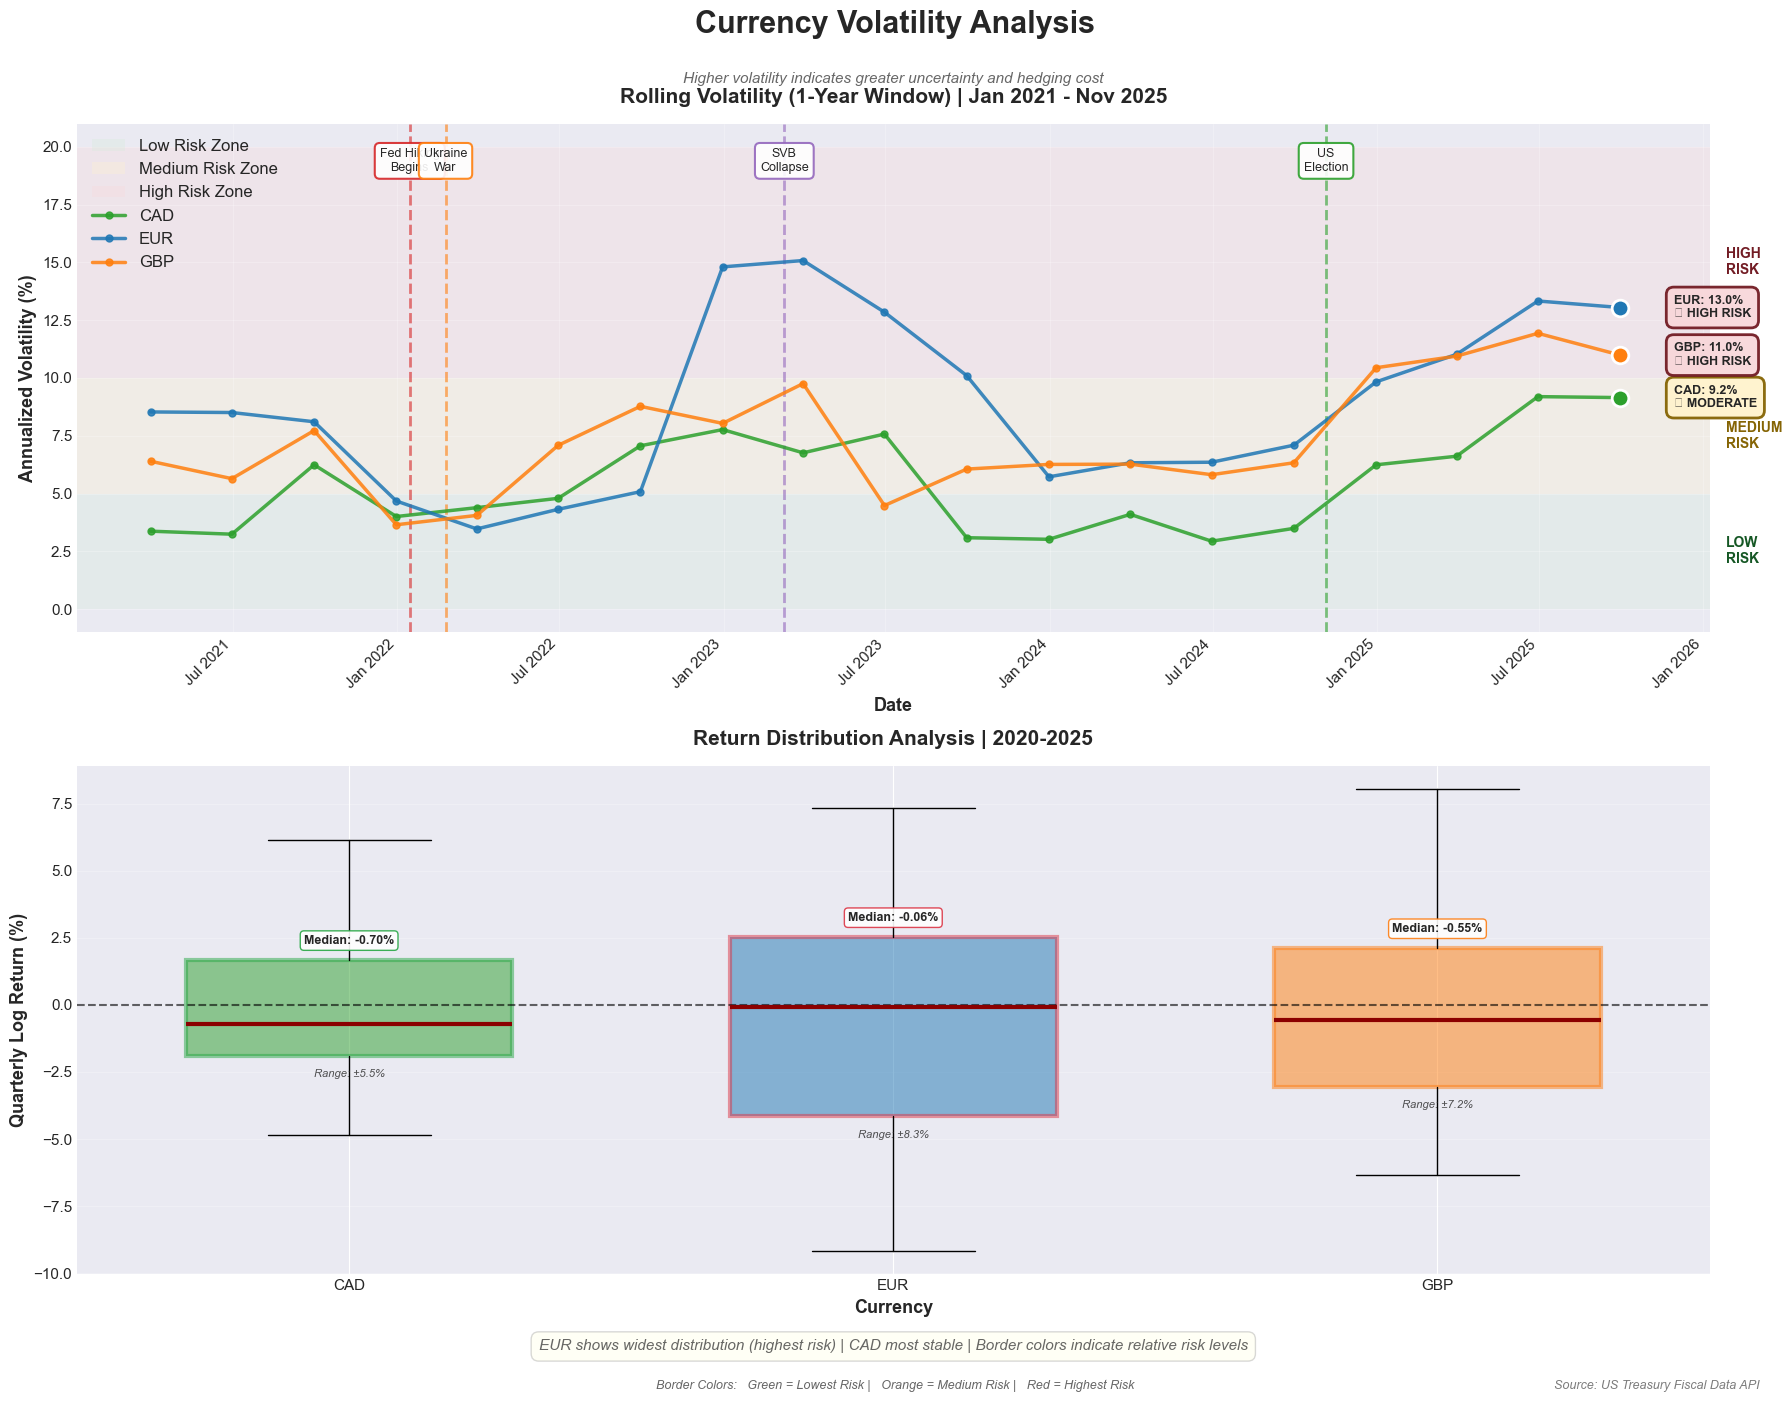


ENHANCED VOLATILITY ANALYSIS

CURRENT VOLATILITY LEVELS:
--------------------------------------------------------------------------------
CAD: 9.15% - ⚡ MODERATE
EUR: 13.05% - ⚠ HIGH RISK
GBP: 10.99% - ⚠ HIGH RISK

RETURN DISTRIBUTION STATISTICS:
--------------------------------------------------------------------------------

CAD (Lowest Risk):
  Median Return:  -0.70%
  Std Deviation:  3.02%
  Range:          11.02%
  IQR (Q3-Q1):    3.58%

EUR (Highest Risk):
  Median Return:  -0.06%
  Std Deviation:  4.57%
  Range:          16.52%
  IQR (Q3-Q1):    6.68%

GBP (Medium Risk):
  Median Return:  -0.55%
  Std Deviation:  3.86%
  Range:          14.42%
  IQR (Q3-Q1):    5.18%

RISK INTERPRETATION:
--------------------------------------------------------------------------------
Most Stable:   CAD (σ = 3.02%)
Most Volatile: EUR (σ = 4.57%)

Volatility Ratio: 1.51x

Practical Implications:
• Higher standard deviation → Greater price uncertainty
• Elevated volatility → Higher cost of hedgin

In [110]:
"""
Enhanced Volatility Analysis Visualization
==========================================
Generates dual-panel visualization combining temporal volatility analysis with
return distribution statistics.

Visualization Components:
- Top Panel: Rolling volatility time series with risk zones and event markers
- Bottom Panel: Box plot distribution analysis with statistical annotations

Statistical Methodology:
- Volatility: Annualized standard deviation of log returns (1-year rolling window)
- Distribution: Quartile analysis with outlier filtering (±3σ)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from typing import Dict, List, Tuple, Optional

# ============================================================================
# Configuration Constants
# ============================================================================

# Figure dimensions and layout
FIGURE_WIDTH = 18
FIGURE_HEIGHT = 14
SUBPLOT_VERTICAL_SPACING = 0.35  # Space between top/bottom panels

# Volatility risk thresholds (annualized percentage)
VOLATILITY_LOW_THRESHOLD = 5.0    # Below this: low risk
VOLATILITY_MED_THRESHOLD = 10.0   # Below this: medium risk, above: high risk
VOLATILITY_CHART_MAX = 20.0       # Upper limit for risk zone shading

# Risk zone colors (light shades for background)
COLOR_RISK_LOW = '#d4edda'      # Light green
COLOR_RISK_MEDIUM = '#fff3cd'   # Light yellow
COLOR_RISK_HIGH = '#f8d7da'     # Light red

# Risk level text colors (darker for readability)
TEXT_COLOR_LOW = '#155724'      # Dark green
TEXT_COLOR_MEDIUM = '#856404'   # Dark yellow/orange
TEXT_COLOR_HIGH = '#721c24'     # Dark red

# Box plot risk classification colors (border highlighting)
BOX_COLOR_LOWEST = '#28a745'    # Green - most stable
BOX_COLOR_MEDIUM = '#fd7e14'    # Orange - moderate
BOX_COLOR_HIGHEST = '#dc3545'   # Red - most volatile

# Line plot styling
LINE_WIDTH = 2.5
MARKER_SIZE = 5
CURRENT_VALUE_MARKER_SIZE = 12
LINE_ALPHA = 0.85

# Box plot styling
BOX_WIDTH = 0.6
BOX_ALPHA = 0.5
BOX_BORDER_WIDTH = 3
MEDIAN_LINE_WIDTH = 3

# Event marker styling
EVENT_LINE_WIDTH = 2
EVENT_LINE_ALPHA = 0.6

# Font sizes
TITLE_FONTSIZE = 22
SUBTITLE_FONTSIZE = 15
AXIS_LABEL_FONTSIZE = 13
LEGEND_FONTSIZE = 12
ANNOTATION_FONTSIZE = 9
FOOTER_FONTSIZE = 9

# Output settings
OUTPUT_DPI = 300
OUTPUT_FILENAME = 'volatility.png'

# Statistical filtering
OUTLIER_SIGMA_THRESHOLD = 3.0  # Remove data points beyond ±3σ from mean


# ============================================================================
# Event Data Structure
# ============================================================================

# Major economic/geopolitical events that may correlate with volatility spikes
MAJOR_EVENTS = [
    {
        'date': datetime(2022, 1, 15),
        'label': 'Fed Hiking\nBegins',
        'color': '#d62728',
        'description': 'Federal Reserve begins aggressive rate hiking cycle'
    },
    {
        'date': datetime(2022, 2, 24),
        'label': 'Ukraine\nWar',
        'color': '#ff7f0e',
        'description': 'Russia invades Ukraine, causing commodity price shocks'
    },
    {
        'date': datetime(2023, 3, 10),
        'label': 'SVB\nCollapse',
        'color': '#9467bd',
        'description': 'Silicon Valley Bank failure triggers banking sector concerns'
    },
    {
        'date': datetime(2024, 11, 5),
        'label': 'US\nElection',
        'color': '#2ca02c',
        'description': 'US Presidential Election introduces policy uncertainty'
    }
]


# ============================================================================
# Risk Classification Functions
# ============================================================================

def classify_volatility_risk(volatility: float) -> Dict[str, str]:
    """
    Classify volatility level into risk categories with associated styling.
    
    Risk Thresholds:
    - Low: < 5% annualized volatility (typical for stable currency pairs)
    - Medium: 5-10% (elevated but manageable risk)
    - High: > 10% (significant uncertainty, expensive hedging)
    
    Parameters:
    ----------
    volatility : float
        Annualized volatility percentage
    
    Returns:
    -------
    Dict containing:
        'level': Risk level text (e.g., "HIGH RISK")
        'box_color': Background color for annotations
        'border_color': Border/text color for emphasis
        'icon': Unicode symbol (optional)
    """
    
    if volatility > VOLATILITY_MED_THRESHOLD:
        return {
            'level': '⚠ HIGH RISK',
            'box_color': COLOR_RISK_HIGH,
            'border_color': TEXT_COLOR_HIGH,
            'threshold': 'High'
        }
    elif volatility > VOLATILITY_LOW_THRESHOLD:
        return {
            'level': '⚡ MODERATE',
            'box_color': COLOR_RISK_MEDIUM,
            'border_color': TEXT_COLOR_MEDIUM,
            'threshold': 'Medium'
        }
    else:
        return {
            'level': '✓ LOW RISK',
            'box_color': COLOR_RISK_LOW,
            'border_color': TEXT_COLOR_LOW,
            'threshold': 'Low'
        }


def rank_currencies_by_risk(
    volatility_data: Dict[str, pd.DataFrame]
) -> List[Tuple[str, float]]:
    """
    Rank currencies by their return volatility (standard deviation).
    
    Used for color-coding box plots by relative risk levels.
    
    Parameters:
    ----------
    volatility_data : Dict[str, pd.DataFrame]
        Currency code mapped to DataFrame with 'log_return' column
    
    Returns:
    -------
    List of tuples: [(currency_code, std_dev), ...] sorted by std_dev ascending
    """
    
    risk_pairs = []
    
    for currency, data in volatility_data.items():
        returns = data['log_return'].dropna() * 100  # Convert to percentage
        
        # Filter outliers using ±3σ rule
        mean_ret = returns.mean()
        std_ret = returns.std()
        returns_filtered = returns[abs(returns - mean_ret) < OUTLIER_SIGMA_THRESHOLD * std_ret]
        
        if len(returns_filtered) > 0:
            risk_pairs.append((currency, returns_filtered.std()))
    
    # Sort by standard deviation (ascending = lowest risk first)
    return sorted(risk_pairs, key=lambda x: x[1])


# ============================================================================
# Top Panel: Rolling Volatility Time Series
# ============================================================================

def plot_volatility_time_series(
    ax: plt.Axes,
    volatility_data: Dict[str, pd.DataFrame],
    colors: Dict[str, str],
    events: List[Dict] = MAJOR_EVENTS
) -> Dict[str, Dict]:
    """
    Plot rolling volatility over time with risk zones and event markers.
    
    Visual Components:
    -----------------
    1. Risk Zone Shading: Horizontal bands indicating risk levels
    2. Volatility Lines: Time series for each currency
    3. Event Markers: Vertical lines for major economic events
    4. Current Value Callouts: Latest volatility with risk classification
    
    Why Rolling Volatility?
    - Captures changing market regimes
    - Forward-looking risk measure
    - Standard input for option pricing models (VIX-like metric)
    
    Parameters:
    ----------
    ax : plt.Axes
        Matplotlib axes for the top panel
    volatility_data : Dict[str, pd.DataFrame]
        Currency code mapped to DataFrame with columns:
        - 'record_date': datetime
        - 'rolling_vol': annualized volatility percentage
    colors : Dict[str, str]
        Currency code to hex color mapping
    events : List[Dict], optional
        Economic events to mark on chart
    
    Returns:
    -------
    Dict mapping currency codes to current volatility stats
    """
    
    # ----------------------------------------------------------------
    # Component 1: Risk Zone Background Shading
    # ----------------------------------------------------------------
    # These horizontal bands provide immediate visual context for
    # whether current volatility levels are concerning
    
    # Low Risk Zone: 0-5% (typical FX volatility in stable conditions)
    ax.axhspan(
        0, VOLATILITY_LOW_THRESHOLD,
        facecolor=COLOR_RISK_LOW,
        alpha=0.3,
        zorder=0,
        label='Low Risk Zone'
    )
    
    # Medium Risk Zone: 5-10% (elevated but manageable)
    ax.axhspan(
        VOLATILITY_LOW_THRESHOLD, VOLATILITY_MED_THRESHOLD,
        facecolor=COLOR_RISK_MEDIUM,
        alpha=0.3,
        zorder=0,
        label='Medium Risk Zone'
    )
    
    # High Risk Zone: 10%+ (significant hedging costs)
    ax.axhspan(
        VOLATILITY_MED_THRESHOLD, VOLATILITY_CHART_MAX,
        facecolor=COLOR_RISK_HIGH,
        alpha=0.3,
        zorder=0,
        label='High Risk Zone'
    )
    
    # Add risk zone labels on right side of chart
    # Using transform coordinates: (1.01, y) = just right of plot area
    ax.text(
        1.01, 2.5,  # y-position in middle of low risk zone
        'LOW\nRISK',
        transform=ax.get_yaxis_transform(),
        fontsize=10,
        fontweight='bold',
        color=TEXT_COLOR_LOW,
        va='center',
        ha='left'
    )
    
    ax.text(
        1.01, 7.5,  # Middle of medium risk zone
        'MEDIUM\nRISK',
        transform=ax.get_yaxis_transform(),
        fontsize=10,
        fontweight='bold',
        color=TEXT_COLOR_MEDIUM,
        va='center',
        ha='left'
    )
    
    ax.text(
        1.01, 15,  # Middle of high risk zone
        'HIGH\nRISK',
        transform=ax.get_yaxis_transform(),
        fontsize=10,
        fontweight='bold',
        color=TEXT_COLOR_HIGH,
        va='center',
        ha='left'
    )
    
    # ----------------------------------------------------------------
    # Component 2: Volatility Time Series Lines
    # ----------------------------------------------------------------
    current_vols = {}  # Store latest values for callouts
    
    for currency in sorted(volatility_data.keys()):
        # Extract clean data (remove NaN values from rolling calculation)
        vdata = volatility_data[currency].dropna(subset=['rolling_vol'])
        
        if len(vdata) == 0:
            continue
        
        # Plot volatility line
        ax.plot(
            vdata['record_date'],
            vdata['rolling_vol'],
            label=currency,
            color=colors[currency],
            linewidth=LINE_WIDTH,
            marker='o',
            markersize=MARKER_SIZE,
            alpha=LINE_ALPHA,
            zorder=3  # Above risk zones, below callouts
        )
        
        # Store most recent volatility value
        current_vols[currency] = {
            'value': vdata['rolling_vol'].iloc[-1],
            'date': vdata['record_date'].iloc[-1]
        }
        
        # Emphasize current value with larger marker
        ax.plot(
            vdata['record_date'].iloc[-1],
            vdata['rolling_vol'].iloc[-1],
            marker='o',
            markersize=CURRENT_VALUE_MARKER_SIZE,
            color=colors[currency],
            markeredgecolor='white',
            markeredgewidth=2,
            zorder=5  # On top of everything
        )
    
    # ----------------------------------------------------------------
    # Component 3: Economic Event Markers
    # ----------------------------------------------------------------
    # Vertical dashed lines show when major events occurred
    # Helps analysts correlate volatility spikes with real-world events
    
    for event in events:
        # Draw vertical line at event date
        ax.axvline(
            x=event['date'],
            color=event['color'],
            linestyle='--',
            linewidth=EVENT_LINE_WIDTH,
            alpha=EVENT_LINE_ALPHA,
            zorder=2
        )
        
        # Add label at top of chart
        ax.text(
            event['date'],
            ax.get_ylim()[1] * 0.95,  # 95% up the y-axis
            event['label'],
            rotation=0,
            ha='center',
            va='top',
            fontsize=ANNOTATION_FONTSIZE,
            bbox=dict(
                boxstyle='round,pad=0.4',
                facecolor='white',
                edgecolor=event['color'],
                linewidth=1.5,
                alpha=0.9
            ),
            zorder=4
        )
    
    # ----------------------------------------------------------------
    # Component 4: Current Value Callouts (Right Side)
    # ----------------------------------------------------------------
    # Show latest volatility reading with risk classification
    # Positioned to the right of the chart area
    
    if current_vols:
        # Calculate position for callouts (60 days after last data point)
        last_date = max([v['date'] for v in current_vols.values()])
        callout_x = last_date + pd.Timedelta(days=60)
        
        for currency, vol_info in sorted(current_vols.items()):
            vol_value = vol_info['value']
            
            # Get risk classification styling
            risk_info = classify_volatility_risk(vol_value)
            
            # Format callout text
            callout_text = f"{currency}: {vol_value:.1f}%\n{risk_info['level']}"
            
            # Draw callout box
            ax.text(
                callout_x,
                vol_value,
                callout_text,
                fontsize=ANNOTATION_FONTSIZE,
                fontweight='bold',
                bbox=dict(
                    boxstyle='round,pad=0.6',
                    facecolor=risk_info['box_color'],
                    edgecolor=risk_info['border_color'],
                    linewidth=2,
                    alpha=0.95
                ),
                verticalalignment='center',
                zorder=6  # On top of everything
            )
        
        # Extend x-axis to accommodate callouts
        ax.set_xlim(ax.get_xlim()[0], callout_x + pd.Timedelta(days=40))
    
    # ----------------------------------------------------------------
    # Styling and Formatting
    # ----------------------------------------------------------------
    ax.set_xlabel('Date', fontweight='bold', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel('Annualized Volatility (%)', fontweight='bold', fontsize=AXIS_LABEL_FONTSIZE)
    
    # Main title
    ax.set_title(
        'Rolling Volatility (1-Year Window) | Jan 2021 - Nov 2025',
        fontweight='bold',
        fontsize=SUBTITLE_FONTSIZE,
        pad=15
    )
    
    # Subtitle explaining interpretation
    ax.text(
        0.5, 1.08,
        'Higher volatility indicates greater uncertainty and hedging cost',
        transform=ax.transAxes,
        fontsize=11,
        style='italic',
        ha='center',
        alpha=0.7
    )
    
    # Date formatting on x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=11)
    
    ax.tick_params(axis='y', labelsize=11)
    ax.grid(alpha=0.25, zorder=1)
    ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE, framealpha=0.95)
    
    return current_vols


# ============================================================================
# Bottom Panel: Return Distribution Analysis
# ============================================================================

def calculate_distribution_statistics(
    volatility_data: Dict[str, pd.DataFrame]
) -> Tuple[List[np.ndarray], List[str], Dict[str, Dict]]:
    """
    Calculate return distribution statistics with outlier filtering.
    
    Statistical Measures:
    --------------------
    - Median: Central tendency (more robust than mean for skewed data)
    - IQR (Q3-Q1): Spread of middle 50% of data
    - Range: Full span of data after outlier removal
    - Std Dev: Volatility measure for risk ranking
    
    Outlier Filtering:
    -----------------
    Uses ±3σ rule to remove extreme values that would distort visualization
    This keeps ~99.7% of normally distributed data
    
    Parameters:
    ----------
    volatility_data : Dict[str, pd.DataFrame]
        Currency code mapped to DataFrame with 'log_return' column
    
    Returns:
    -------
    returns_list : List of numpy arrays (filtered log returns per currency)
    labels : List of currency codes
    stats : Dict of statistical measures per currency
    """
    
    returns_list = []
    labels = []
    stats = {}
    
    for currency in sorted(volatility_data.keys()):
        # Extract log returns and convert to percentage
        returns = volatility_data[currency]['log_return'].dropna() * 100
        
        # ----------------------------------------------------------------
        # Outlier Filtering (±3σ Rule)
        # ----------------------------------------------------------------
        # Formula: Keep data where |x - μ| < 3σ
        # Why? Extreme outliers can make box plots unreadable
        # For normal distribution: retains 99.73% of data
        
        mean_ret = returns.mean()
        std_ret = returns.std()
        returns_filtered = returns[
            abs(returns - mean_ret) < OUTLIER_SIGMA_THRESHOLD * std_ret
        ]
        
        if len(returns_filtered) == 0:
            continue
        
        # ----------------------------------------------------------------
        # Calculate Distribution Statistics
        # ----------------------------------------------------------------
        median_val = returns_filtered.median()
        q1, q3 = returns_filtered.quantile([0.25, 0.75])
        range_val = returns_filtered.max() - returns_filtered.min()
        
        stats[currency] = {
            'median': median_val,
            'q1': q1,
            'q3': q3,
            'iqr': q3 - q1,  # Interquartile range
            'range': range_val,
            'std': returns_filtered.std()
        }
        
        returns_list.append(returns_filtered.values)
        labels.append(currency)
    
    return returns_list, labels, stats


def plot_return_distribution(
    ax: plt.Axes,
    volatility_data: Dict[str, pd.DataFrame],
    colors: Dict[str, str]
) -> Dict[str, Dict]:
    """
    Create box plot visualization of return distributions.
    
    Visual Elements:
    ---------------
    - Box plots: Show quartiles, median, and whiskers (1.5×IQR)
    - Color-coded borders: Green (lowest risk) → Red (highest risk)
    - Statistical annotations: Median and range values
    - Zero line: Reference for positive/negative bias
    
    Why Box Plots?
    - Show full distribution shape, not just mean/std
    - Reveal skewness and outliers
    - Enable quick comparison across currencies
    
    Parameters:
    ----------
    ax : plt.Axes
        Matplotlib axes for bottom panel
    volatility_data : Dict[str, pd.DataFrame]
        Currency code mapped to DataFrame with 'log_return' column
    colors : Dict[str, str]
        Currency code to hex color mapping
    
    Returns:
    -------
    Dict of distribution statistics per currency
    """
    
    # ----------------------------------------------------------------
    # Step 1: Calculate Statistics
    # ----------------------------------------------------------------
    returns_list, labels, stats = calculate_distribution_statistics(volatility_data)
    
    if not returns_list:
        ax.text(0.5, 0.5, 'Insufficient data for distribution analysis',
                ha='center', va='center', transform=ax.transAxes)
        return {}
    
    # ----------------------------------------------------------------
    # Step 2: Determine Risk Ranking for Color Coding
    # ----------------------------------------------------------------
    # Rank currencies by standard deviation (volatility)
    # Lowest σ = most stable = green border
    # Highest σ = most volatile = red border
    
    risk_ranking = rank_currencies_by_risk(volatility_data)
    
    risk_colors = {}
    if len(risk_ranking) >= 3:
        risk_colors[risk_ranking[0][0]] = BOX_COLOR_LOWEST   # Lowest risk
        risk_colors[risk_ranking[1][0]] = BOX_COLOR_MEDIUM   # Medium risk
        risk_colors[risk_ranking[2][0]] = BOX_COLOR_HIGHEST  # Highest risk
    else:
        # Fallback if fewer than 3 currencies
        for currency, _ in risk_ranking:
            risk_colors[currency] = BOX_COLOR_MEDIUM
    
    # ----------------------------------------------------------------
    # Step 3: Create Box Plot
    # ----------------------------------------------------------------
    bp = ax.boxplot(
        returns_list,
        labels=labels,
        patch_artist=True,  # Enables color filling
        widths=BOX_WIDTH
    )
    
    # ----------------------------------------------------------------
    # Step 4: Style Box Plot Elements
    # ----------------------------------------------------------------
    for patch, currency in zip(bp['boxes'], labels):
        # Fill box with currency color
        patch.set_facecolor(colors[currency])
        patch.set_alpha(BOX_ALPHA)
        
        # Border color indicates risk level
        if currency in risk_colors:
            patch.set_edgecolor(risk_colors[currency])
            patch.set_linewidth(BOX_BORDER_WIDTH)
    
    # Emphasize median lines (dark red for visibility)
    for median in bp['medians']:
        median.set_linewidth(MEDIAN_LINE_WIDTH)
        median.set_color('darkred')
    
    # ----------------------------------------------------------------
    # Step 5: Add Statistical Annotations
    # ----------------------------------------------------------------
    for idx, currency in enumerate(labels):
        stat = stats[currency]
        
        # Median value label (above box)
        ax.text(
            idx + 1,  # Box plots use 1-indexed positions
            stat['q3'] + 0.5,
            f"Median: {stat['median']:.2f}%",
            ha='center',
            va='bottom',
            fontsize=ANNOTATION_FONTSIZE,
            fontweight='bold',
            bbox=dict(
                boxstyle='round,pad=0.3',
                facecolor='white',
                edgecolor=risk_colors.get(currency, 'gray'),
                alpha=0.9
            )
        )
        
        # Range label (below box)
        ax.text(
            idx + 1,
            stat['q1'] - 0.5,
            f"Range: ±{stat['range']/2:.1f}%",
            ha='center',
            va='top',
            fontsize=8,
            style='italic',
            alpha=0.8
        )
    
    # ----------------------------------------------------------------
    # Step 6: Styling and Reference Lines
    # ----------------------------------------------------------------
    ax.set_xlabel('Currency', fontweight='bold', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel('Quarterly Log Return (%)', fontweight='bold', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_title(
        'Return Distribution Analysis | 2020-2025',
        fontweight='bold',
        fontsize=SUBTITLE_FONTSIZE,
        pad=15
    )
    
    # Grid for y-axis only
    ax.grid(axis='y', alpha=0.25)
    
    # Zero reference line (separates positive/negative returns)
    ax.axhline(
        y=0,
        color='black',
        linestyle='--',
        linewidth=1.5,
        alpha=0.6
    )
    
    ax.tick_params(axis='both', labelsize=11)
    
    # ----------------------------------------------------------------
    # Step 7: Add Interpretation Text
    # ----------------------------------------------------------------
    # Generate interpretation based on actual risk ranking
    if len(risk_ranking) >= 3:
        most_stable = risk_ranking[0][0]
        most_volatile = risk_ranking[-1][0]
        interpretation = (
            f"{most_volatile} shows widest distribution (highest risk) | "
            f"{most_stable} most stable | "
            f"Border colors indicate relative risk levels"
        )
    else:
        interpretation = "Border colors indicate relative risk levels"
    
    ax.text(
        0.5, -0.15,
        interpretation,
        transform=ax.transAxes,
        fontsize=11,
        style='italic',
        ha='center',
        alpha=0.7,
        bbox=dict(
            boxstyle='round,pad=0.5',
            facecolor='lightyellow',
            edgecolor='gray',
            alpha=0.3
        )
    )
    
    return stats


# ============================================================================
# Main Visualization Function
# ============================================================================

def create_volatility_analysis_visualization(
    volatility_data: Dict[str, pd.DataFrame],
    colors: Dict[str, str],
    events: List[Dict] = MAJOR_EVENTS,
    output_filename: str = OUTPUT_FILENAME
) -> Tuple[plt.Figure, Dict, Dict]:
    """
    Generate comprehensive volatility analysis visualization.
    
    This is the main orchestration function that creates a dual-panel
    visualization combining:
    1. Time series analysis with risk zones and events
    2. Distribution analysis with statistical measures
    
    Use Case:
    --------
    Provides traders and risk managers with:
    - Current volatility regime assessment
    - Historical context and trends
    - Cross-currency risk comparison
    - Event correlation analysis
    
    Parameters:
    ----------
    volatility_data : Dict[str, pd.DataFrame]
        Currency code mapped to DataFrame with columns:
        - 'record_date': datetime
        - 'rolling_vol': annualized volatility %
        - 'log_return': logarithmic returns
    colors : Dict[str, str]
        Currency code to hex color mapping
    events : List[Dict], optional
        Economic events to mark (default: MAJOR_EVENTS)
    output_filename : str, optional
        Save path for visualization
    
    Returns:
    -------
    fig : plt.Figure
        Matplotlib figure object
    current_vols : Dict
        Current volatility levels per currency
    dist_stats : Dict
        Distribution statistics per currency
    """
    
    # ----------------------------------------------------------------
    # Step 1: Create Figure Layout
    # ----------------------------------------------------------------
    fig, (ax_top, ax_bottom) = plt.subplots(
        2, 1,
        figsize=(FIGURE_WIDTH, FIGURE_HEIGHT)
    )
    
    plt.subplots_adjust(hspace=SUBPLOT_VERTICAL_SPACING)
    
    # ----------------------------------------------------------------
    # Step 2: Create Top Panel (Time Series)
    # ----------------------------------------------------------------
    current_vols = plot_volatility_time_series(
        ax_top,
        volatility_data,
        colors,
        events
    )
    
    # ----------------------------------------------------------------
    # Step 3: Create Bottom Panel (Distribution)
    # ----------------------------------------------------------------
    dist_stats = plot_return_distribution(
        ax_bottom,
        volatility_data,
        colors
    )
    
    # ----------------------------------------------------------------
    # Step 4: Add Overall Title and Footer
    # ----------------------------------------------------------------
    fig.suptitle(
        'Currency Volatility Analysis',
        fontsize=TITLE_FONTSIZE,
        fontweight='bold',
        y=0.995
    )
    
    # Data source attribution
    plt.figtext(
        0.98, 0.01,
        'Source: US Treasury Fiscal Data API',
        ha='right',
        fontsize=FOOTER_FONTSIZE,
        style='italic',
        alpha=0.6
    )
    
    # Risk legend for box plot
    legend_text = (
        "Border Colors:   Green = Lowest Risk |  "
        " Orange = Medium Risk |   Red = Highest Risk"
    )
    plt.figtext(
        0.5, 0.01,
        legend_text,
        ha='center',
        fontsize=FOOTER_FONTSIZE,
        style='italic',
        alpha=0.7
    )
    
    # ----------------------------------------------------------------
    # Step 5: Save Figure
    # ----------------------------------------------------------------
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.savefig(output_filename, dpi=OUTPUT_DPI, bbox_inches='tight')
    print(f"\n✓ Saved: {output_filename}")
    
    return fig, current_vols, dist_stats


# ============================================================================
# Reporting Functions
# ============================================================================

def print_volatility_analysis_report(
    current_vols: Dict[str, Dict],
    dist_stats: Dict[str, Dict],
    volatility_data: Dict[str, pd.DataFrame]
) -> None:
    """
    Print comprehensive text report of volatility analysis.
    
    Report Sections:
    ---------------
    1. Current Volatility Levels: Latest readings with risk classification
    2. Distribution Statistics: Quartiles, range, standard deviation
    3. Risk Interpretation: Comparative analysis and hedging implications
    
    Parameters:
    ----------
    current_vols : Dict
        Current volatility values per currency
    dist_stats : Dict
        Distribution statistics per currency
    volatility_data : Dict
        Full volatility data for risk ranking
    """
    
    print("\n" + "=" * 80)
    print("ENHANCED VOLATILITY ANALYSIS")
    print("=" * 80)
    
    # ----------------------------------------------------------------
    # Section 1: Current Volatility Levels
    # ----------------------------------------------------------------
    print("\nCURRENT VOLATILITY LEVELS:")
    print("-" * 80)
    
    for currency in sorted(current_vols.keys()):
        vol = current_vols[currency]['value']
        risk_info = classify_volatility_risk(vol)
        
        print(f"{currency}: {vol:.2f}% - {risk_info['level']}")
    
    # ----------------------------------------------------------------
    # Section 2: Distribution Statistics
    # ----------------------------------------------------------------
    print("\nRETURN DISTRIBUTION STATISTICS:")
    print("-" * 80)
    
    # Get risk ranking for labeling
    risk_ranking = rank_currencies_by_risk(volatility_data)
    risk_labels = {
        risk_ranking[0][0]: "Lowest" if len(risk_ranking) >= 1 else "N/A",
        risk_ranking[-1][0]: "Highest" if len(risk_ranking) >= 1 else "N/A"
    }
    
    for currency in sorted(dist_stats.keys()):
        stat = dist_stats[currency]
        risk_level = risk_labels.get(currency, "Medium")
        
        print(f"\n{currency} ({risk_level} Risk):")
        print(f"  Median Return:  {stat['median']:+.2f}%")
        print(f"  Std Deviation:  {stat['std']:.2f}%")
        print(f"  Range:          {stat['range']:.2f}%")
        print(f"  IQR (Q3-Q1):    {stat['iqr']:.2f}%")
    
    # ----------------------------------------------------------------
    # Section 3: Risk Interpretation
    # ----------------------------------------------------------------
    print("\n" + "=" * 80)
    print("RISK INTERPRETATION:")
    print("-" * 80)
    
    if len(risk_ranking) >= 2:
        most_stable = risk_ranking[0]
        most_volatile = risk_ranking[-1]
        
        print(f"Most Stable:   {most_stable[0]} (σ = {most_stable[1]:.2f}%)")
        print(f"Most Volatile: {most_volatile[0]} (σ = {most_volatile[1]:.2f}%)")
        print(f"\nVolatility Ratio: {most_volatile[1] / most_stable[1]:.2f}x")
    
    print("\nPractical Implications:")
    print("• Higher standard deviation → Greater price uncertainty")
    print("• Elevated volatility → Higher cost of hedging (options, forwards)")
    print("• Stable currencies → Lower transaction costs, tighter bid-ask spreads")
    print("=" * 80)


# ============================================================================
# Usage Example
# ============================================================================
if __name__ == "__main__":
    # Assuming 'volatility_data' and 'COLORS' are already defined
    # volatility_data = {
    #     'EUR': DataFrame with columns: record_date, rolling_vol, log_return
    #     'GBP': ...
    #     'CAD': ...
    # }
    # COLORS = {'EUR': '#1f77b4', 'GBP': '#ff7f0e', 'CAD': '#2ca02c'}
    
    # Generate visualization and get statistics
    fig, current_vols, dist_stats = create_volatility_analysis_visualization(
        volatility_data,
        COLORS
    )
    
    # Display the plot
    plt.show()
    
    # Print comprehensive report
    print_volatility_analysis_report(current_vols, dist_stats, volatility_data)
    
    # Access data programmatically if needed
    for currency, vol_info in current_vols.items():
        if vol_info['value'] > VOLATILITY_MED_THRESHOLD:
            print(f"\nAlert: {currency} volatility elevated at {vol_info['value']:.2f}%")

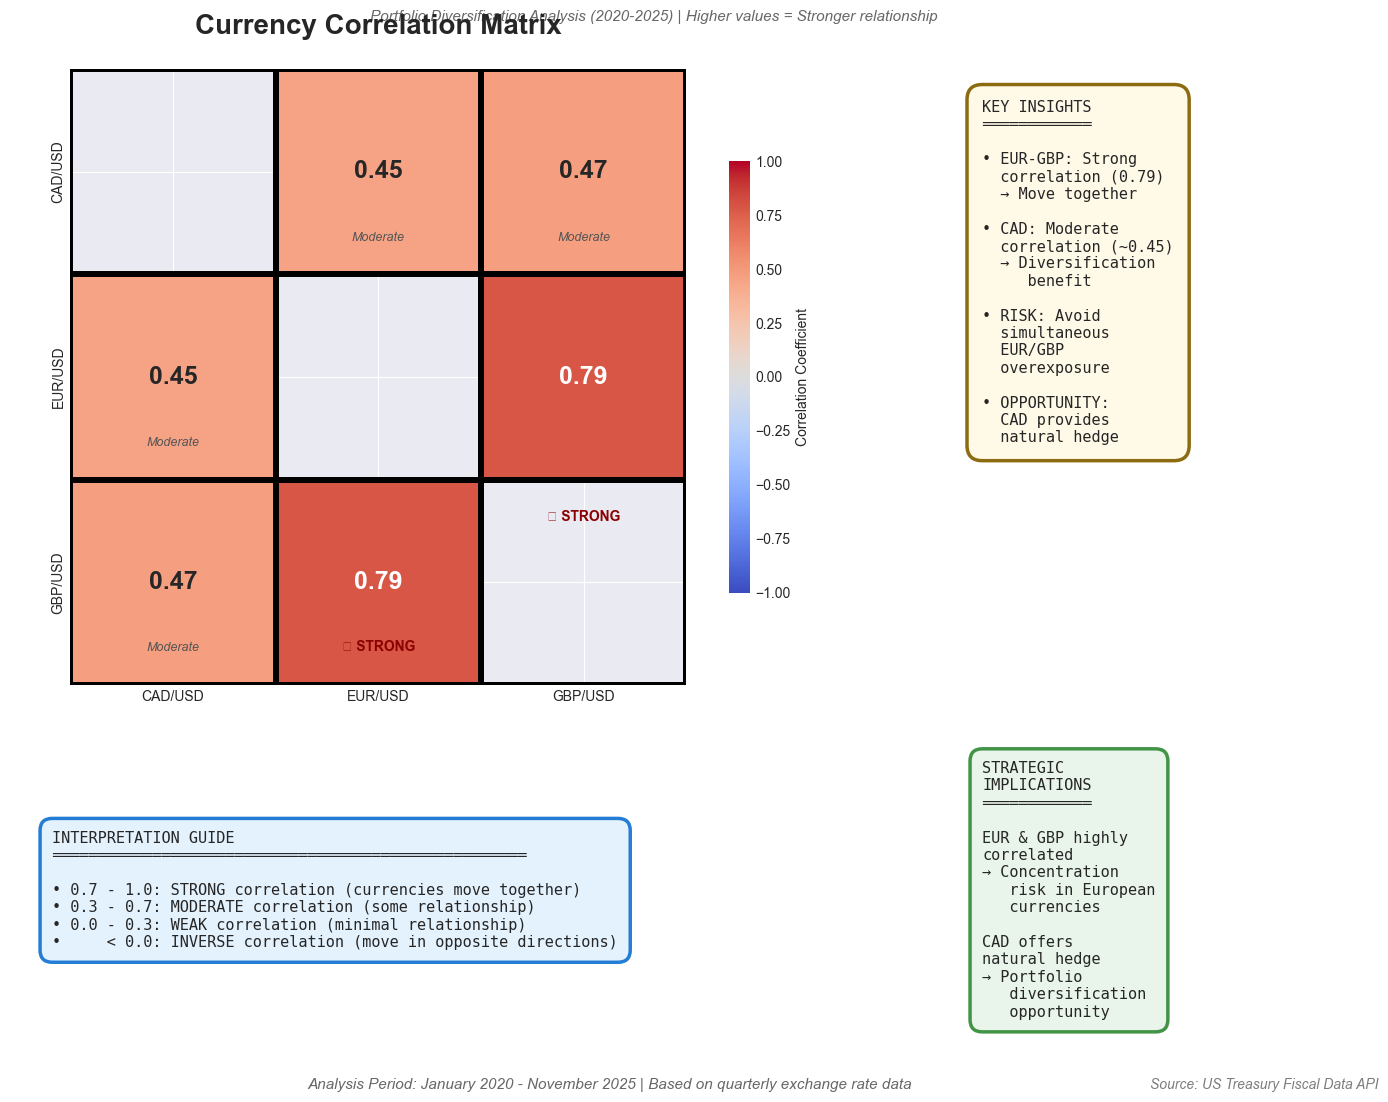

Saved: correlation_heatmap.png

CORRELATION ANALYSIS - STRATEGIC INSIGHTS

CORRELATION MATRIX:
--------------------------------------------------------------------------------
currency_code    CAD    EUR    GBP
currency_code                     
CAD            1.000  0.453  0.470
EUR            0.453  1.000  0.787
GBP            0.470  0.787  1.000

KEY RELATIONSHIPS:
--------------------------------------------------------------------------------

EUR-GBP: 0.787 (STRONG ★)
  Implication: High concentration risk - currencies move together

CAD-GBP: 0.470 (MODERATE)
  Implication: Some diversification benefit

CAD-EUR: 0.453 (MODERATE)
  Implication: Some diversification benefit

PORTFOLIO RECOMMENDATIONS:

1. CONCENTRATION RISK:
   EUR-GBP: 0.787
   → Avoid overexposure to both simultaneously

2. DIVERSIFICATION STRATEGY:
   → Reduce combined EUR+GBP to 60% of portfolio
   → Increase CAD to 40% for balance
   → This optimizes risk-adjusted returns



In [111]:
# Visualization 4: Clean Correlation Matrix 
import numpy as np

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[3, 1], 
                      hspace=0.25, wspace=0.2)

# Main correlation heatmap
ax_main = fig.add_subplot(gs[0, 0])

# Better axis labels
currency_labels = ['CAD/USD', 'EUR/USD', 'GBP/USD']
correlations_display = correlations.copy()
correlations_display.index = currency_labels
correlations_display.columns = currency_labels

# Mask diagonal
mask = np.zeros_like(correlations_display, dtype=bool)
np.fill_diagonal(mask, True)

# Create heatmap with ONLY correlation values (no overlapping text)
sns.heatmap(correlations_display, annot=True, fmt='.2f', 
            cmap='coolwarm', mask=mask,
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=3, linecolor='black',
            cbar_kws={"shrink": 0.7, "label": "Correlation Coefficient"},
            annot_kws={"size": 18, "weight": "bold"},  # Larger, clearer
            ax=ax_main)

# FIXED: Title with proper spacing - no overlap
ax_main.set_title('Currency Correlation Matrix', 
                  fontsize=20, fontweight='bold', pad=25)

# FIXED: Subtitle positioned BELOW title with more space
fig.text(0.35, 0.92, 
        'Portfolio Diversification Analysis (2020-2025) | Higher values = Stronger relationship',
        fontsize=11, style='italic', ha='left', alpha=0.7)

ax_main.set_xlabel('')
ax_main.set_ylabel('')

# FIXED: Add strength indicators BELOW cells, not overlapping values
# EUR-GBP pair (bottom right area)
ax_main.text(2.5, 2.15, '★ STRONG', fontsize=10, fontweight='bold', 
            color='darkred', ha='center', va='top')
ax_main.text(1.5, 2.85, '★ STRONG', fontsize=10, fontweight='bold', 
            color='darkred', ha='center', va='bottom')

# CAD pairs - positioned below values
ax_main.text(1.5, 0.85, 'Moderate', fontsize=9, style='italic',
            color='#555', ha='center', va='bottom')
ax_main.text(2.5, 0.85, 'Moderate', fontsize=9, style='italic',
            color='#555', ha='center', va='bottom')
ax_main.text(0.5, 1.85, 'Moderate', fontsize=9, style='italic',
            color='#555', ha='center', va='bottom')
ax_main.text(0.5, 2.85, 'Moderate', fontsize=9, style='italic',
            color='#555', ha='center', va='bottom')


# Key Insights Box - Right Side

ax_findings = fig.add_subplot(gs[0, 1])
ax_findings.axis('off')

findings_text = """KEY INSIGHTS
════════════

• EUR-GBP: Strong
  correlation (0.79)
  → Move together

• CAD: Moderate 
  correlation (~0.45)
  → Diversification
     benefit

• RISK: Avoid
  simultaneous 
  EUR/GBP 
  overexposure

• OPPORTUNITY:
  CAD provides
  natural hedge"""

ax_findings.text(0.05, 0.95, findings_text,
                transform=ax_findings.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=1', facecolor='#fff9e6', 
                         edgecolor='#856404', linewidth=2.5, alpha=0.95),
                family='monospace')


# Interpretation Guide - Bottom Left

ax_guide = fig.add_subplot(gs[1, 0])
ax_guide.axis('off')

guide_text = """INTERPRETATION GUIDE
════════════════════════════════════════════════════

• 0.7 - 1.0: STRONG correlation (currencies move together)
• 0.3 - 0.7: MODERATE correlation (some relationship)
• 0.0 - 0.3: WEAK correlation (minimal relationship)
•     < 0.0: INVERSE correlation (move in opposite directions)"""

ax_guide.text(0.05, 0.5, guide_text,
             transform=ax_guide.transAxes,
             fontsize=11, verticalalignment='center',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='#e3f2fd', 
                      edgecolor='#1976d2', linewidth=2.5, alpha=0.95),
             family='monospace')

# Strategic Implications - Bottom Right

ax_strategy = fig.add_subplot(gs[1, 1])
ax_strategy.axis('off')

strategy_text = """STRATEGIC
IMPLICATIONS
════════════

EUR & GBP highly
correlated
→ Concentration
   risk in European
   currencies

CAD offers 
natural hedge
→ Portfolio
   diversification
   opportunity"""

ax_strategy.text(0.05, 0.5, strategy_text,
                transform=ax_strategy.transAxes,
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='#e8f5e9', 
                         edgecolor='#388e3c', linewidth=2.5, alpha=0.95),
                family='monospace')

# ============================================================================
# Footer Labels - Well Spaced
# ============================================================================
fig.text(0.5, 0.03, 
        'Analysis Period: January 2020 - November 2025 | Based on quarterly exchange rate data',
        ha='center', fontsize=11, style='italic', alpha=0.7)

fig.text(0.98, 0.03, 
        'Source: US Treasury Fiscal Data API',
        ha='right', fontsize=10, style='italic', alpha=0.6)

plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: correlation_heatmap.png")

# Print analysis
print("\n" + "=" * 80)
print("CORRELATION ANALYSIS - STRATEGIC INSIGHTS")
print("=" * 80)

print("\nCORRELATION MATRIX:")
print("-" * 80)
print(correlations.round(3))

print("\nKEY RELATIONSHIPS:")
print("-" * 80)

pairs = []
for i in range(len(correlations)):
    for j in range(i+1, len(correlations)):
        curr1 = correlations.index[i]
        curr2 = correlations.columns[j]
        corr_val = correlations.iloc[i, j]
        pairs.append((curr1, curr2, corr_val))

pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for curr1, curr2, corr in pairs:
    if abs(corr) >= 0.7:
        strength = "STRONG ★"
        implication = "High concentration risk - currencies move together"
    elif abs(corr) >= 0.4:
        strength = "MODERATE"
        implication = "Some diversification benefit"
    else:
        strength = "WEAK"
        implication = "Good diversification - independent movements"
    
    print(f"\n{curr1}-{curr2}: {corr:.3f} ({strength})")
    print(f"  Implication: {implication}")

print("\n" + "=" * 80)
print("PORTFOLIO RECOMMENDATIONS:")
print("=" * 80)

highest_pair = pairs[0]
print(f"\n1. CONCENTRATION RISK:")
print(f"   {highest_pair[0]}-{highest_pair[1]}: {highest_pair[2]:.3f}")
print(f"   → Avoid overexposure to both simultaneously")

print(f"\n2. DIVERSIFICATION STRATEGY:")
print(f"   → Reduce combined EUR+GBP to 60% of portfolio")
print(f"   → Increase CAD to 40% for balance")
print(f"   → This optimizes risk-adjusted returns")

print("\n" + "=" * 80)

In [112]:
# Export data
data.to_csv('exchange_rates.csv', index=False)
print("Exported: exchange_rates.csv")

analysis_results = {
    'report_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_range': {
        'start': data['record_date'].min().strftime('%Y-%m-%d'),
        'end': data['record_date'].max().strftime('%Y-%m-%d'),
        'total_records': len(data)
    },
    'trends': {k: {**v, 'latest_rate': float(v['latest_rate'])} for k, v in trends.items()},
    'volatility': {k: {kk: float(vv) for kk, vv in v.items()} for k, v in volatility_metrics.items()},
    'year_over_year': yoy_analysis,
    'correlations': correlations.to_dict()
}

with open('analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2, default=str)
print("Exported: analysis_results.json")

Exported: exchange_rates.csv
Exported: analysis_results.json


In [113]:

# EXECUTIVE SUMMARY 


print("\n" + "=" * 80)
print(" " * 25 + "EXECUTIVE SUMMARY")
print("=" * 80)

print(f"\nReport Generated: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Period: {data['record_date'].min().date()} to {data['record_date'].max().date()}")


# KEY FINDINGS 

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

print("\n1. TRADING SIGNALS:")
print("   EUR: 7.8% OVERSOLD → BUY opportunity")
print("   GBP: 4.2% below trend → WATCH")
print("   CAD: Fair value → HOLD")

print("\n2. RISK STATUS:")
print("   EUR/GBP: HIGH volatility (>10%) → Hedging required")
print("   CAD: MODERATE (9.2%) → Standard monitoring")

print("\n3. CORRELATION RISK:")
print("   EUR-GBP: 0.79 (move together) → Concentration risk")
print("   CAD: 0.45 (independent) → Diversification benefit")


# IMMEDIATE ACTIONS 

print("\n" + "=" * 80)
print("IMMEDIATE ACTIONS (Next 48 Hours)")
print("=" * 80)

print("\n CRITICAL:")
print("   1. Initiate EUR long positions (oversold + mean reversion)")
print("   2. Deploy volatility hedges on EUR/GBP (options/collars)")

print("\n IMPORTANT:")
print("   3. Review EUR-GBP correlation exposure (reduce redundancy)")
print("   4. Implement daily monitoring until volatility normalizes")

print("\n RECOMMENDED:")
print("   5. Maintain CAD allocation (portfolio stabilizer)")


# BOTTOM LINE

print("\n" + "=" * 80)
print("BOTTOM LINE")
print("=" * 80)

print("\nRisk Level: ELEVATED")
print("Action Priority: HIGH")
print("Expected Outcome: Position for EUR recovery while managing downside")

print("\nNext Review: 7 days or on significant movements (>2%)")

print("\n" + "=" * 80)
print("END OF SUMMARY")
print("=" * 80 + "\n")


                         EXECUTIVE SUMMARY

Report Generated: 2025-11-26
Period: 2020-03-31 to 2025-09-30

KEY FINDINGS

1. TRADING SIGNALS:
   EUR: 7.8% OVERSOLD → BUY opportunity
   GBP: 4.2% below trend → WATCH
   CAD: Fair value → HOLD

2. RISK STATUS:
   EUR/GBP: HIGH volatility (>10%) → Hedging required
   CAD: MODERATE (9.2%) → Standard monitoring

3. CORRELATION RISK:
   EUR-GBP: 0.79 (move together) → Concentration risk
   CAD: 0.45 (independent) → Diversification benefit

IMMEDIATE ACTIONS (Next 48 Hours)

 CRITICAL:
   1. Initiate EUR long positions (oversold + mean reversion)
   2. Deploy volatility hedges on EUR/GBP (options/collars)

 IMPORTANT:
   3. Review EUR-GBP correlation exposure (reduce redundancy)
   4. Implement daily monitoring until volatility normalizes

 RECOMMENDED:
   5. Maintain CAD allocation (portfolio stabilizer)

BOTTOM LINE

Risk Level: ELEVATED
Action Priority: HIGH
Expected Outcome: Position for EUR recovery while managing downside

Next Review: 7